In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculate du^ n / dt^n for arbitrary n and use this to create a loss term
def higher_order_loss_term(weight, outputs, t, norm_term, forcing_funct):
    
    # compute derivative of outputs with respect to inputs 
    deriv_to_t = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs), 
                                 create_graph=True)[0]
          
    # additional loss term
#     loss_term = norm_term * weight * torch.mean((deriv_to_t + forcing_funct) ** 2)
    loss_term = weight * torch.mean((deriv_to_t + forcing_funct) ** 2)
    
    return loss_term, deriv_to_t

# build the loss function
def loss(t, As, lambda_vals, model, loss_term_weights):
            
    # create the trial solution
    u1_t = lambda t: model(t)[0][:, 0].unsqueeze(dim=1)
    u2_t = lambda t: model(t)[0][:, 1].unsqueeze(dim=1)
    
    # normalize loss and use it to compute the normalization factor
    norm_term1, norm_term2 = 1 / As[0] ** 2, 1 / As[1] ** 2
    
    # initialize all loss terms in case they do not need to be computed
    L_D, L_DD, L_DDD, L_DDDD = [torch.tensor([[0.]])] * 4
    
    # loss results
    loss_dict = {}
    
    # define f (aka forcing function) for each differential equation
    f1 = lambda t, u: lambda_vals[0] * u # lambda_vals[0] = 2
    f2 = lambda t, u: lambda_vals[1] * u # lambda_vals[1] = 3
    
    # compute u1(t) and u2(t)
    outputs1, outputs2 = u1_t(t), u2_t(t)
        
    # initial value loss terms
    initial_val_loss1 = (As[0] - u1_t(torch.tensor([[0]], dtype=torch.float32)))**2
    initial_val_loss2 = (As[1] - u2_t(torch.tensor([[0]], dtype=torch.float32)))**2
    
    print(initial_val_loss1, initial_val_loss2)
    initial_val_loss = initial_val_loss1 + initial_val_loss2

    # computes residual (function call also returns du / dt as u_t_x)
    L_D1, u_t_x1 = higher_order_loss_term(loss_term_weights[0], outputs1, t, norm_term1, f1(t, outputs2))
    L_D2, u_t_x2 = higher_order_loss_term(loss_term_weights[0], outputs2, t, norm_term2, f2(t, outputs1))
    L_D = L_D1 + L_D2     
    
#     if loss_term_weights[1] or loss_term_weights[2] or loss_term_weights[3]:
#         # define f' (derivative of f)
#         f_t = lambda_val * u_t_x
#         # first derivative of residual (function call also returns d^2u / dt^2 as u_tt_x)
#         L_DD, u_tt_x = higher_order_loss_term(loss_term_weights[1], u_t_x, t, norm_term, f_t)

#     if loss_term_weights[2] or loss_term_weights[3]:
#         # define f'' (derivative of f')
#         f_tt = lambda_val * u_tt_x
#         # second derivative of residual (function call also returns d^3u / dt^3 as u_ttt_x)
#         L_DDD, u_ttt_x = higher_order_loss_term(loss_term_weights[2], u_tt_x, t, norm_term, f_tt)
        
#     if loss_term_weights[3]:
#         # define f''' (derivative of f'')
#         f_ttt = lambda_val * u_ttt_x
#         # third derivative of residual (function call also returns d^4u / dt^4 as u_tttt_x)
#         L_DDDD, u_tttt_x = higher_order_loss_term(loss_term_weights[3], u_ttt_x, t, norm_term, f_ttt)
        
    # total loss 
    L_total = L_D + L_DD + L_DDD + L_DDDD + initial_val_loss
    
    loss_dict['L_D'] = L_D
    loss_dict['L_DD'] = L_DD
    loss_dict['L_DDD'] = L_DDD
    loss_dict['L_DDDD'] = L_DDDD
    loss_dict['L_total'] = L_total

    return loss_dict


In [3]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size):
        super(BuildNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        self.output = nn.Linear(h_size3, output_size) # bias = True
        
    def forward(self, x):
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        result = self.output(h)
        
        return result, h

In [4]:
# train and evaluate the model
def run_model(iterations, min_x, max_x, A_vals, lambda_vals, loss_term_weights):
    
    assert sum(loss_term_weights) != 0, "ERROR: Invalid Loss Function"
    
    for idx, num in enumerate(loss_term_weights[:-1]):
        next_num = loss_term_weights[idx + 1]
        assert next_num <= num, 'ERROR: Invalid Loss Function'
      
    # build the neural net model
    model = BuildNetwork(1, 64, 64, 128, 2)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # starting initial value for transfer learning
    curr_A_indx = 0
    A = A_vals[curr_A_indx]
    print(f"Initial Condition: {A}")
    # run the training loop
    for i in range(iterations):
        
        if i % 2000 == 0 and i != 0: 
            curr_A_indx += 1 
            A = A_vals[curr_A_indx]
            print(f"Initial Condition: {A}")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, lambda_vals, model, loss_term_weights)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['LDD_losses'].append(curr_loss['L_DD'].item())
        loss_history['LDDD_losses'].append(curr_loss['L_DDD'].item())
        loss_history['LDDDD_losses'].append(curr_loss['L_DDDD'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse
#         with torch.no_grad():
# #             true_sol1 = (A * np.exp(-lambda_val * x)).numpy()
# #             network_sol1 = model(x)[0][:, 0].numpy()
#             e_term1, e_term2 = np.exp(-np.sqrt(6) * x), np.exp(2 * np.sqrt(6) * x)
#             true_sol1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (A[1] * e_term1 * (e_term2 - 1)) / np.sqrt(6)).numpy()
#             network_sol1 = model(x)[0][:, 0].numpy()
            
#             true_sol2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - 0.5 * np.sqrt(1.5) * A[0] * e_term1 * (e_term2 - 1)).numpy()
#             network_sol2 = model(x)[0][:, 1].numpy()
            
#         current_mse = np.mean((true_sol1 - network_sol1) ** 2) + np.mean((true_sol2 - network_sol2) ** 2)
#         MSEs.append(current_mse)
   
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

In [ ]:
# # function to plot the neural network vs exact solution
# def plot_solution(min_x, max_x, As, lambda_vals, trained_model, axis):
    
#     u1_t = lambda t: trained_model(t)[0][:, 0]
#     u2_t = lambda t: trained_model(t)[0][:, 1]
    
#     # plot the solution accuracies
#     xx = np.linspace(min_x, max_x, 200)[:, None]

#     with torch.no_grad():
#         yy1 = u1_t(torch.Tensor(xx)).numpy()
#         yy2 = u2_t(torch.Tensor(xx)).numpy()

#     e_term1, e_term2 = np.exp(-np.sqrt(6) * xx), np.exp(2 * np.sqrt(6) * xx)
#     yt1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (A[1] * e_term1 * (e_term2 - 1)) / np.sqrt(6)).numpy()
#     yt2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - 0.5 * np.sqrt(1.5) * A[0] * e_term1 * (e_term2 - 1)).numpy()

#     axis.plot(xx, yt1, label='Actual Solution $u_1(t)$')
#     axis.plot(xx, yt2, label='Actual Solution $u_2(t)$')
#     axis.plot(xx, yy1, '--', label='Neural Network Solution $u_1(t)$')
#     axis.plot(xx, yy2, '--', label='Neural Network Solution $u_2(t)$')
#     axis.set_title("u(t) vs t for Actual and Approximation")
#     axis.set_xlabel('$t$')
#     axis.set_ylabel('$u(t)$')
#     axis.legend(loc='best')
    
# # function to plot the overall loss of the network solution
# def plot_total_loss(iterations, train_losses, axis, loss_label):
#     axis.plot(range(iterations), train_losses, label=loss_label)
#     axis.set_yscale("log")
#     axis.set_title("Total Loss vs Iterations")
#     axis.set_xlabel('Iterations')
#     axis.set_ylabel('Loss')
#     axis.legend(loc='best')
    
# # function to plot the MSEs
# def plot_mse(iterations, mses, axis):
#     axis.plot(range(iterations), mses, label='MSE')
#     axis.set_yscale("log")
#     axis.set_title("MSE vs Iterations")
#     axis.set_xlabel('Iterations')
#     axis.set_ylabel('MSE')
#     axis.legend(loc='best')
    
# # wrapper function to plot the solution and the overall loss of the network solution
# def plot_loss_mse_and_solution(min_x, max_x, A, lambda_val, iterations, 
#                                trained_model, train_losses, loss_label, mses):
#     fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
#     plot_total_loss(iterations=iterations, train_losses=train_losses, 
#                     axis=axs[0], loss_label=loss_label)
#     plot_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
#                   trained_model=trained_model, axis=axs[1])
#     plot_mse(iterations=iterations, mses=mses, axis=axs[2])
    
#     plt.show()
    
# # function to plot the loss terms for a given model
# def plot_individual_loss_terms(iterations, loss_dictionary):
    
#     plt.figure(figsize=(9, 9))
#     for label, losses in loss_dictionary.items():
#         plt.plot(range(iterations), losses, label=label)
        
#     plt.yscale("log")
#     plt.title("Loss Terms vs Iterations")
#     plt.xlabel('Iterations')
#     plt.ylabel('Loss')
#     plt.legend(loc='best')
#     plt.grid()
#     plt.show()

In [13]:
# set-up differential equation parameters for network
min_x, max_x = 0, 2
# A_vals = [0.9, 0.2, 0.35, 0.75]
A_vals = [[0.75, 0.25], [0.75, 0.25], [0.75, 0.25], [0.75, 0.25], [0.75, 0.25]]
lambda_vals = [1.1, 1.1]
iterations = 10000

# run model which has a loss of the MSE (i.e. no higher order terms)
loss_history_w1, trained_model_w1, time_w1, MSE_w1 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                              lambda_vals=lambda_vals, loss_term_weights=[1, 0, 0, 0])

if False:
    
    # run model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    loss_history_w2, trained_model_w2, time_w2, MSE_w2 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 0, 0])


    # run model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    loss_history_w3, trained_model_w3, time_w3, MSE_w3 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 1, 0])

    # run model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    loss_history_w4, trained_model_w4, time_w4, MSE_w4 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 1, 1])

Initial Condition: [0.75, 0.25]
tensor([[0.5632]], grad_fn=<PowBackward0>) tensor([[0.0548]], grad_fn=<PowBackward0>)
tensor([[0.5402]], grad_fn=<PowBackward0>) tensor([[0.0525]], grad_fn=<PowBackward0>)
tensor([[0.4988]], grad_fn=<PowBackward0>) tensor([[0.0483]], grad_fn=<PowBackward0>)
tensor([[0.4440]], grad_fn=<PowBackward0>) tensor([[0.0426]], grad_fn=<PowBackward0>)
tensor([[0.3816]], grad_fn=<PowBackward0>) tensor([[0.0361]], grad_fn=<PowBackward0>)
tensor([[0.3167]], grad_fn=<PowBackward0>) tensor([[0.0290]], grad_fn=<PowBackward0>)
tensor([[0.2539]], grad_fn=<PowBackward0>) tensor([[0.0221]], grad_fn=<PowBackward0>)
tensor([[0.1967]], grad_fn=<PowBackward0>) tensor([[0.0156]], grad_fn=<PowBackward0>)
tensor([[0.1471]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.1064]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0745]], grad_fn=<PowBackward0>) tensor([[0.0023]], grad_fn=<PowBackward0>)
tensor([[0.0508]], gra

tensor([[0.0218]], grad_fn=<PowBackward0>) tensor([[0.0136]], grad_fn=<PowBackward0>)
tensor([[0.0217]], grad_fn=<PowBackward0>) tensor([[0.0136]], grad_fn=<PowBackward0>)
tensor([[0.0216]], grad_fn=<PowBackward0>) tensor([[0.0136]], grad_fn=<PowBackward0>)
tensor([[0.0216]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0216]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0217]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0218]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0218]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0219]], grad_fn=<PowBackward0>) tensor([[0.0139]], grad_fn=<PowBackward0>)
tensor([[0.0219]], grad_fn=<PowBackward0>) tensor([[0.0139]], grad_fn=<PowBackward0>)
tensor([[0.0220]], grad_fn=<PowBackward0>) tensor([[0.0139]], grad_fn=<PowBackward0>)
tensor([[0.0220]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0188]], grad_fn=<PowBackward0>) tensor([[0.0148]], grad_fn=<PowBackward0>)
tensor([[0.0188]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0187]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0186]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0186]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0186]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0185]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0185]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0184]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0184]], grad_fn=<PowBackward0>) tensor([[0.0149]], grad_fn=<PowBackward0>)
tensor([[0.0183]], grad_fn=<PowBackward0>) tensor([[0.0148]], grad_fn=<PowBackward0>)
tensor([[0.0183]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0151]], grad_fn=<PowBackward0>)
tensor([[0.0170]], grad_fn=<PowBackward0>) tensor([[0.0151]], grad_fn=<PowBackward0>)
tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0171]], grad_fn=<PowBackward0>) tensor([[0.0153]], grad_fn=<PowBackward0>)
tensor([[0.0172]], grad_fn=<PowBackward0>) tensor([[0.0153]], grad_fn=<PowBackward0>)
tensor([[0.0172]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0172]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0166]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0166]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0165]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0165]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0165]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0165]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0164]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0164]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0164]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0164]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0164]], grad_fn=<PowBackward0>) tensor([[0.0154]], grad_fn=<PowBackward0>)
tensor([[0.0163]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0160]], grad_fn=<PowBackward0>) tensor([[0.0151]], grad_fn=<PowBackward0>)
tensor([[0.0160]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0160]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0160]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0160]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0160]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0159]], grad_fn=<PowBackward0>) tensor([[0.0152]], grad_fn=<PowBackward0>)
tensor([[0.0159]], grad_fn=<PowBackward0>) tensor([[0.0151]], grad_fn=<PowBackward0>)
tensor([[0.0159]], grad_fn=<PowBackward0>) tensor([[0.0151]], grad_fn=<PowBackward0>)
tensor([[0.0159]], grad_fn=<PowBackward0>) tensor([[0.0151]], grad_fn=<PowBackward0>)
tensor([[0.0158]], grad_fn=<PowBackward0>) tensor([[0.0151]], grad_fn=<PowBackward0>)
tensor([[0.0158]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0153]], grad_fn=<PowBackward0>) tensor([[0.0147]], grad_fn=<PowBackward0>)
tensor([[0.0152]], grad_fn=<PowBackward0>) tensor([[0.0146]], grad_fn=<PowBackward0>)
tensor([[0.0151]], grad_fn=<PowBackward0>) tensor([[0.0146]], grad_fn=<PowBackward0>)
tensor([[0.0150]], grad_fn=<PowBackward0>) tensor([[0.0145]], grad_fn=<PowBackward0>)
tensor([[0.0149]], grad_fn=<PowBackward0>) tensor([[0.0145]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0145]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0147]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0147]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0147]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0146]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0146]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0147]], grad_fn=<PowBackward0>) tensor([[0.0142]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0143]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0143]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0143]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0143]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0143]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0143]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0148]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0149]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0149]], grad_fn=<PowBackward0>) tensor([[0.0144]], grad_fn=<PowBackward0>)
tensor([[0.0149]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0141]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0139]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0139]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0140]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0140]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0140]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0140]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0140]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0140]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0137]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0138]], grad_fn=<PowBackward0>)
tensor([[0.0144]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0141]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0143]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0142]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0140]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0140]], grad_fn=<PowBackward0>) tensor([[0.0135]], grad_fn=<PowBackward0>)
tensor([[0.0140]], grad_fn=<PowBackward0>) tensor([[0.0134]], grad_fn=<PowBackward0>)
tensor([[0.0139]], grad_fn=<PowBackward0>) tensor([[0.0134]], grad_fn=<PowBackward0>)
tensor([[0.0138]], grad_fn=<PowBackward0>) tensor([[0.0134]], grad_fn=<PowBackward0>)
tensor([[0.0137]], grad_fn=<PowBackward0>) tensor([[0.0133]], grad_fn=<PowBackward0>)
tensor([[0.0137]], grad_fn=<PowBackward0>) tensor([[0.0133]], grad_fn=<PowBackward0>)
tensor([[0.0136]], grad_fn=<PowBackward0>) tensor([[0.0132]], grad_fn=<PowBackward0>)
tensor([[0.0136]], grad_fn=<PowBackward0>) tensor([[0.0132]], grad_fn=<PowBackward0>)
tensor([[0.0136]], grad_fn=<PowBackward0>) tensor([[0.0132]], grad_fn=<PowBackward0>)
tensor([[0.0136]], grad_fn=<PowBackward0>) tensor([[0.0132]], grad_fn=<PowBackward0>)
tensor([[0.0136]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0134]], grad_fn=<PowBackward0>) tensor([[0.0131]], grad_fn=<PowBackward0>)
tensor([[0.0133]], grad_fn=<PowBackward0>) tensor([[0.0130]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0130]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0128]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0128]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0128]], grad_fn=<PowBackward0>)
tensor([[0.0133]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0133]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0131]], grad_fn=<PowBackward0>) tensor([[0.0126]], grad_fn=<PowBackward0>)
tensor([[0.0131]], grad_fn=<PowBackward0>) tensor([[0.0126]], grad_fn=<PowBackward0>)
tensor([[0.0130]], grad_fn=<PowBackward0>) tensor([[0.0125]], grad_fn=<PowBackward0>)
tensor([[0.0130]], grad_fn=<PowBackward0>) tensor([[0.0125]], grad_fn=<PowBackward0>)
tensor([[0.0130]], grad_fn=<PowBackward0>) tensor([[0.0125]], grad_fn=<PowBackward0>)
tensor([[0.0130]], grad_fn=<PowBackward0>) tensor([[0.0125]], grad_fn=<PowBackward0>)
tensor([[0.0130]], grad_fn=<PowBackward0>) tensor([[0.0125]], grad_fn=<PowBackward0>)
tensor([[0.0131]], grad_fn=<PowBackward0>) tensor([[0.0125]], grad_fn=<PowBackward0>)
tensor([[0.0131]], grad_fn=<PowBackward0>) tensor([[0.0126]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0126]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0126]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0134]], grad_fn=<PowBackward0>) tensor([[0.0128]], grad_fn=<PowBackward0>)
tensor([[0.0135]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0135]], grad_fn=<PowBackward0>) tensor([[0.0130]], grad_fn=<PowBackward0>)
tensor([[0.0135]], grad_fn=<PowBackward0>) tensor([[0.0130]], grad_fn=<PowBackward0>)
tensor([[0.0135]], grad_fn=<PowBackward0>) tensor([[0.0130]], grad_fn=<PowBackward0>)
tensor([[0.0134]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0133]], grad_fn=<PowBackward0>) tensor([[0.0129]], grad_fn=<PowBackward0>)
tensor([[0.0132]], grad_fn=<PowBackward0>) tensor([[0.0128]], grad_fn=<PowBackward0>)
tensor([[0.0131]], grad_fn=<PowBackward0>) tensor([[0.0128]], grad_fn=<PowBackward0>)
tensor([[0.0129]], grad_fn=<PowBackward0>) tensor([[0.0127]], grad_fn=<PowBackward0>)
tensor([[0.0128]], grad_fn=<PowBackward0>) tensor([[0.0126]], grad_fn=<PowBackward0>)
tensor([[0.0127]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0128]], grad_fn=<PowBackward0>) tensor([[0.0124]], grad_fn=<PowBackward0>)
tensor([[0.0128]], grad_fn=<PowBackward0>) tensor([[0.0124]], grad_fn=<PowBackward0>)
tensor([[0.0128]], grad_fn=<PowBackward0>) tensor([[0.0124]], grad_fn=<PowBackward0>)
tensor([[0.0128]], grad_fn=<PowBackward0>) tensor([[0.0124]], grad_fn=<PowBackward0>)
tensor([[0.0129]], grad_fn=<PowBackward0>) tensor([[0.0124]], grad_fn=<PowBackward0>)
tensor([[0.0129]], grad_fn=<PowBackward0>) tensor([[0.0124]], grad_fn=<PowBackward0>)
tensor([[0.0129]], grad_fn=<PowBackward0>) tensor([[0.0124]], grad_fn=<PowBackward0>)
tensor([[0.0128]], grad_fn=<PowBackward0>) tensor([[0.0123]], grad_fn=<PowBackward0>)
tensor([[0.0128]], grad_fn=<PowBackward0>) tensor([[0.0123]], grad_fn=<PowBackward0>)
tensor([[0.0127]], grad_fn=<PowBackward0>) tensor([[0.0122]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.0121]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0120]], grad_fn=<PowBackward0>)
tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0120]], grad_fn=<PowBackward0>)
tensor([[0.0123]], grad_fn=<PowBackward0>) tensor([[0.0121]], grad_fn=<PowBackward0>)
tensor([[0.0124]], grad_fn=<PowBackward0>) tensor([[0.0121]], grad_fn=<PowBackward0>)
tensor([[0.0125]], grad_fn=<PowBackward0>) tensor([[0.0122]], grad_fn=<PowBackward0>)
tensor([[0.0125]], grad_fn=<PowBackward0>) tensor([[0.0122]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.0122]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.0123]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.0123]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.0123]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.0123]], grad_fn=<PowBackward0>)
tensor([[0.0126]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0119]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0118]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0117]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0118]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0118]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0119]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0119]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0121]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0121]], grad_fn=<PowBackward0>) tensor([[0.0117]], grad_fn=<PowBackward0>)
tensor([[0.0121]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.0118]], grad_fn=<PowBackward0>)
tensor([[0.0122]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0117]], grad_fn=<PowBackward0>) tensor([[0.0114]], grad_fn=<PowBackward0>)
tensor([[0.0118]], grad_fn=<PowBackward0>) tensor([[0.0114]], grad_fn=<PowBackward0>)
tensor([[0.0119]], grad_fn=<PowBackward0>) tensor([[0.0115]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0116]], grad_fn=<PowBackward0>)
tensor([[0.0121]], grad_fn=<PowBackward0>) tensor([[0.0116]], grad_fn=<PowBackward0>)
tensor([[0.0121]], grad_fn=<PowBackward0>) tensor([[0.0116]], grad_fn=<PowBackward0>)
tensor([[0.0121]], grad_fn=<PowBackward0>) tensor([[0.0116]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0116]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0116]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0116]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.0115]], grad_fn=<PowBackward0>)
tensor([[0.0120]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0115]], grad_fn=<PowBackward0>) tensor([[0.0113]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0113]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0113]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0113]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0113]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0112]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0112]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0112]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0111]], grad_fn=<PowBackward0>)
tensor([[0.0116]], grad_fn=<PowBackward0>) tensor([[0.0111]], grad_fn=<PowBackward0>)
tensor([[0.0115]], grad_fn=<PowBackward0>) tensor([[0.0111]], grad_fn=<PowBackward0>)
tensor([[0.0115]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0115]], grad_fn=<PowBackward0>) tensor([[0.0111]], grad_fn=<PowBackward0>)
tensor([[0.0115]], grad_fn=<PowBackward0>) tensor([[0.0111]], grad_fn=<PowBackward0>)
tensor([[0.0114]], grad_fn=<PowBackward0>) tensor([[0.0111]], grad_fn=<PowBackward0>)
tensor([[0.0114]], grad_fn=<PowBackward0>) tensor([[0.0110]], grad_fn=<PowBackward0>)
tensor([[0.0113]], grad_fn=<PowBackward0>) tensor([[0.0109]], grad_fn=<PowBackward0>)
tensor([[0.0112]], grad_fn=<PowBackward0>) tensor([[0.0109]], grad_fn=<PowBackward0>)
tensor([[0.0111]], grad_fn=<PowBackward0>) tensor([[0.0108]], grad_fn=<PowBackward0>)
tensor([[0.0111]], grad_fn=<PowBackward0>) tensor([[0.0108]], grad_fn=<PowBackward0>)
tensor([[0.0111]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0108]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0108]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0108]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0108]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0110]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0111]], grad_fn=<PowBackward0>) tensor([[0.0107]], grad_fn=<PowBackward0>)
tensor([[0.0112]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0107]], grad_fn=<PowBackward0>) tensor([[0.0104]], grad_fn=<PowBackward0>)
tensor([[0.0108]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0108]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0108]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0108]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0108]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0107]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0107]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0107]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0107]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0106]], grad_fn=<PowBackward0>) tensor([[0.0105]], grad_fn=<PowBackward0>)
tensor([[0.0106]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0104]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.0104]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.0104]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.0104]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.0104]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.0104]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.0104]], grad_fn=<PowBackward0>) tensor([[0.0100]], grad_fn=<PowBackward0>)
tensor([[0.0103]], grad_fn=<PowBackward0>) tensor([[0.0099]], grad_fn=<PowBackward0>)
tensor([[0.0103]], grad_fn=<PowBackward0>) tensor([[0.0099]], grad_fn=<PowBackward0>)
tensor([[0.0103]], grad_fn=<PowBackward0>) tensor([[0.0099]], grad_fn=<PowBackward0>)
tensor([[0.0103]], grad_fn=<PowBackward0>) tensor([[0.0099]], grad_fn=<PowBackward0>)
tensor([[0.0103]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0098]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0098]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0098]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0097]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0097]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0097]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0097]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0097]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0097]], grad_fn=<PowBackward0>)
tensor([[0.0101]], grad_fn=<PowBackward0>) tensor([[0.0098]], grad_fn=<PowBackward0>)
tensor([[0.0102]], grad_fn=<PowBackward0>) tensor([[0.0098]], grad_fn=<PowBackward0>)
tensor([[0.0102]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0098]], grad_fn=<PowBackward0>) tensor([[0.0096]], grad_fn=<PowBackward0>)
tensor([[0.0098]], grad_fn=<PowBackward0>) tensor([[0.0096]], grad_fn=<PowBackward0>)
tensor([[0.0099]], grad_fn=<PowBackward0>) tensor([[0.0096]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0096]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0096]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0096]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0096]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0095]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0095]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0095]], grad_fn=<PowBackward0>)
tensor([[0.0100]], grad_fn=<PowBackward0>) tensor([[0.0095]], grad_fn=<PowBackward0>)
tensor([[0.0099]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0091]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0090]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0091]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0090]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0090]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0090]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0091]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0090]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0090]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0090]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.0091]], grad_fn=<PowBackward0>)
tensor([[0.0094]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0091]], grad_fn=<PowBackward0>) tensor([[0.0089]], grad_fn=<PowBackward0>)
tensor([[0.0091]], grad_fn=<PowBackward0>) tensor([[0.0088]], grad_fn=<PowBackward0>)
tensor([[0.0090]], grad_fn=<PowBackward0>) tensor([[0.0087]], grad_fn=<PowBackward0>)
tensor([[0.0089]], grad_fn=<PowBackward0>) tensor([[0.0087]], grad_fn=<PowBackward0>)
tensor([[0.0089]], grad_fn=<PowBackward0>) tensor([[0.0087]], grad_fn=<PowBackward0>)
tensor([[0.0089]], grad_fn=<PowBackward0>) tensor([[0.0086]], grad_fn=<PowBackward0>)
tensor([[0.0088]], grad_fn=<PowBackward0>) tensor([[0.0086]], grad_fn=<PowBackward0>)
tensor([[0.0088]], grad_fn=<PowBackward0>) tensor([[0.0086]], grad_fn=<PowBackward0>)
tensor([[0.0088]], grad_fn=<PowBackward0>) tensor([[0.0087]], grad_fn=<PowBackward0>)
tensor([[0.0089]], grad_fn=<PowBackward0>) tensor([[0.0087]], grad_fn=<PowBackward0>)
tensor([[0.0089]], grad_fn=<PowBackward0>) tensor([[0.0087]], grad_fn=<PowBackward0>)
tensor([[0.0089]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0087]], grad_fn=<PowBackward0>) tensor([[0.0085]], grad_fn=<PowBackward0>)
tensor([[0.0087]], grad_fn=<PowBackward0>) tensor([[0.0085]], grad_fn=<PowBackward0>)
tensor([[0.0087]], grad_fn=<PowBackward0>) tensor([[0.0085]], grad_fn=<PowBackward0>)
tensor([[0.0087]], grad_fn=<PowBackward0>) tensor([[0.0085]], grad_fn=<PowBackward0>)
tensor([[0.0086]], grad_fn=<PowBackward0>) tensor([[0.0085]], grad_fn=<PowBackward0>)
tensor([[0.0086]], grad_fn=<PowBackward0>) tensor([[0.0084]], grad_fn=<PowBackward0>)
tensor([[0.0086]], grad_fn=<PowBackward0>) tensor([[0.0084]], grad_fn=<PowBackward0>)
tensor([[0.0085]], grad_fn=<PowBackward0>) tensor([[0.0084]], grad_fn=<PowBackward0>)
tensor([[0.0085]], grad_fn=<PowBackward0>) tensor([[0.0084]], grad_fn=<PowBackward0>)
tensor([[0.0085]], grad_fn=<PowBackward0>) tensor([[0.0083]], grad_fn=<PowBackward0>)
tensor([[0.0084]], grad_fn=<PowBackward0>) tensor([[0.0083]], grad_fn=<PowBackward0>)
tensor([[0.0084]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0086]], grad_fn=<PowBackward0>) tensor([[0.0083]], grad_fn=<PowBackward0>)
tensor([[0.0087]], grad_fn=<PowBackward0>) tensor([[0.0083]], grad_fn=<PowBackward0>)
tensor([[0.0087]], grad_fn=<PowBackward0>) tensor([[0.0083]], grad_fn=<PowBackward0>)
tensor([[0.0086]], grad_fn=<PowBackward0>) tensor([[0.0083]], grad_fn=<PowBackward0>)
tensor([[0.0086]], grad_fn=<PowBackward0>) tensor([[0.0082]], grad_fn=<PowBackward0>)
tensor([[0.0086]], grad_fn=<PowBackward0>) tensor([[0.0082]], grad_fn=<PowBackward0>)
tensor([[0.0085]], grad_fn=<PowBackward0>) tensor([[0.0082]], grad_fn=<PowBackward0>)
tensor([[0.0085]], grad_fn=<PowBackward0>) tensor([[0.0082]], grad_fn=<PowBackward0>)
tensor([[0.0084]], grad_fn=<PowBackward0>) tensor([[0.0082]], grad_fn=<PowBackward0>)
tensor([[0.0084]], grad_fn=<PowBackward0>) tensor([[0.0082]], grad_fn=<PowBackward0>)
tensor([[0.0084]], grad_fn=<PowBackward0>) tensor([[0.0082]], grad_fn=<PowBackward0>)
tensor([[0.0084]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0080]], grad_fn=<PowBackward0>) tensor([[0.0078]], grad_fn=<PowBackward0>)
tensor([[0.0080]], grad_fn=<PowBackward0>) tensor([[0.0077]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0077]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0077]], grad_fn=<PowBackward0>)
tensor([[0.0080]], grad_fn=<PowBackward0>) tensor([[0.0078]], grad_fn=<PowBackward0>)
tensor([[0.0080]], grad_fn=<PowBackward0>) tensor([[0.0078]], grad_fn=<PowBackward0>)
tensor([[0.0081]], grad_fn=<PowBackward0>) tensor([[0.0079]], grad_fn=<PowBackward0>)
tensor([[0.0081]], grad_fn=<PowBackward0>) tensor([[0.0079]], grad_fn=<PowBackward0>)
tensor([[0.0082]], grad_fn=<PowBackward0>) tensor([[0.0080]], grad_fn=<PowBackward0>)
tensor([[0.0082]], grad_fn=<PowBackward0>) tensor([[0.0080]], grad_fn=<PowBackward0>)
tensor([[0.0083]], grad_fn=<PowBackward0>) tensor([[0.0080]], grad_fn=<PowBackward0>)
tensor([[0.0083]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0076]], grad_fn=<PowBackward0>) tensor([[0.0074]], grad_fn=<PowBackward0>)
tensor([[0.0077]], grad_fn=<PowBackward0>) tensor([[0.0074]], grad_fn=<PowBackward0>)
tensor([[0.0078]], grad_fn=<PowBackward0>) tensor([[0.0075]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0075]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0076]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0076]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0077]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0076]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0077]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0077]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0077]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0076]], grad_fn=<PowBackward0>)
tensor([[0.0079]], grad_fn=<PowBackward0>) tensor([[0.0076]], grad_fn=<PowBackward0>)
tensor([[0.0078]], grad_fn=<PowBackward0>) tensor([[0.0076]], grad_fn=<PowBackward0>)
tensor([[0.0077]], grad_fn=<PowBackward0>) tensor([[0.0075]], grad_fn=<PowBackward0>)
tensor([[0.0076]], grad_fn=<PowBackward0>) tensor([[0.0074]], grad_fn=<PowBackward0>)
tensor([[0.0075]], grad_fn=<PowBackward0>) tensor([[0.0073]], grad_fn=<PowBackward0>)
tensor([[0.0074]], grad_fn=<PowBackward0>) tensor([[0.0072]], grad_fn=<PowBackward0>)
tensor([[0.0073]], grad_fn=<PowBackward0>) tensor([[0.0071]], grad_fn=<PowBackward0>)
tensor([[0.0072]], grad_fn=<PowBackward0>) tensor([[0.0070]], grad_fn=<PowBackward0>)
tensor([[0.0072]], grad_fn=<PowBackward0>) tensor([[0.0070]], grad_fn=<PowBackward0>)
tensor([[0.0073]], grad_fn=<PowBackward0>) tensor([[0.0070]], grad_fn=<PowBackward0>)
tensor([[0.0073]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0068]], grad_fn=<PowBackward0>) tensor([[0.0067]], grad_fn=<PowBackward0>)
tensor([[0.0067]], grad_fn=<PowBackward0>) tensor([[0.0066]], grad_fn=<PowBackward0>)
tensor([[0.0067]], grad_fn=<PowBackward0>) tensor([[0.0067]], grad_fn=<PowBackward0>)
tensor([[0.0067]], grad_fn=<PowBackward0>) tensor([[0.0067]], grad_fn=<PowBackward0>)
tensor([[0.0067]], grad_fn=<PowBackward0>) tensor([[0.0067]], grad_fn=<PowBackward0>)
tensor([[0.0067]], grad_fn=<PowBackward0>) tensor([[0.0067]], grad_fn=<PowBackward0>)
tensor([[0.0068]], grad_fn=<PowBackward0>) tensor([[0.0068]], grad_fn=<PowBackward0>)
tensor([[0.0069]], grad_fn=<PowBackward0>) tensor([[0.0068]], grad_fn=<PowBackward0>)
tensor([[0.0069]], grad_fn=<PowBackward0>) tensor([[0.0068]], grad_fn=<PowBackward0>)
tensor([[0.0070]], grad_fn=<PowBackward0>) tensor([[0.0069]], grad_fn=<PowBackward0>)
tensor([[0.0070]], grad_fn=<PowBackward0>) tensor([[0.0069]], grad_fn=<PowBackward0>)
tensor([[0.0071]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0067]], grad_fn=<PowBackward0>) tensor([[0.0065]], grad_fn=<PowBackward0>)
tensor([[0.0066]], grad_fn=<PowBackward0>) tensor([[0.0065]], grad_fn=<PowBackward0>)
tensor([[0.0065]], grad_fn=<PowBackward0>) tensor([[0.0064]], grad_fn=<PowBackward0>)
tensor([[0.0065]], grad_fn=<PowBackward0>) tensor([[0.0064]], grad_fn=<PowBackward0>)
tensor([[0.0064]], grad_fn=<PowBackward0>) tensor([[0.0063]], grad_fn=<PowBackward0>)
tensor([[0.0065]], grad_fn=<PowBackward0>) tensor([[0.0063]], grad_fn=<PowBackward0>)
tensor([[0.0065]], grad_fn=<PowBackward0>) tensor([[0.0063]], grad_fn=<PowBackward0>)
tensor([[0.0065]], grad_fn=<PowBackward0>) tensor([[0.0063]], grad_fn=<PowBackward0>)
tensor([[0.0066]], grad_fn=<PowBackward0>) tensor([[0.0064]], grad_fn=<PowBackward0>)
tensor([[0.0066]], grad_fn=<PowBackward0>) tensor([[0.0065]], grad_fn=<PowBackward0>)
tensor([[0.0067]], grad_fn=<PowBackward0>) tensor([[0.0065]], grad_fn=<PowBackward0>)
tensor([[0.0068]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0065]], grad_fn=<PowBackward0>) tensor([[0.0063]], grad_fn=<PowBackward0>)
tensor([[0.0066]], grad_fn=<PowBackward0>) tensor([[0.0064]], grad_fn=<PowBackward0>)
tensor([[0.0066]], grad_fn=<PowBackward0>) tensor([[0.0064]], grad_fn=<PowBackward0>)
tensor([[0.0066]], grad_fn=<PowBackward0>) tensor([[0.0064]], grad_fn=<PowBackward0>)
tensor([[0.0065]], grad_fn=<PowBackward0>) tensor([[0.0063]], grad_fn=<PowBackward0>)
tensor([[0.0063]], grad_fn=<PowBackward0>) tensor([[0.0062]], grad_fn=<PowBackward0>)
tensor([[0.0062]], grad_fn=<PowBackward0>) tensor([[0.0061]], grad_fn=<PowBackward0>)
tensor([[0.0060]], grad_fn=<PowBackward0>) tensor([[0.0060]], grad_fn=<PowBackward0>)
tensor([[0.0059]], grad_fn=<PowBackward0>) tensor([[0.0058]], grad_fn=<PowBackward0>)
tensor([[0.0058]], grad_fn=<PowBackward0>) tensor([[0.0058]], grad_fn=<PowBackward0>)
tensor([[0.0058]], grad_fn=<PowBackward0>) tensor([[0.0058]], grad_fn=<PowBackward0>)
tensor([[0.0059]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0060]], grad_fn=<PowBackward0>) tensor([[0.0058]], grad_fn=<PowBackward0>)
tensor([[0.0059]], grad_fn=<PowBackward0>) tensor([[0.0058]], grad_fn=<PowBackward0>)
tensor([[0.0059]], grad_fn=<PowBackward0>) tensor([[0.0057]], grad_fn=<PowBackward0>)
tensor([[0.0058]], grad_fn=<PowBackward0>) tensor([[0.0057]], grad_fn=<PowBackward0>)
tensor([[0.0057]], grad_fn=<PowBackward0>) tensor([[0.0056]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0057]], grad_fn=<PowBackward0>) tensor([[0.0056]], grad_fn=<PowBackward0>)
tensor([[0.0057]], grad_fn=<PowBackward0>) tensor([[0.0056]], grad_fn=<PowBackward0>)
tensor([[0.0058]], grad_fn=<PowBackward0>) tensor([[0.0057]], grad_fn=<PowBackward0>)
tensor([[0.0058]], grad_fn=<PowBackward0>) tensor([[0.0057]], grad_fn=<PowBackward0>)
tensor([[0.0059]], grad_fn=<PowBackward0>) tensor([[0.0057]], grad_fn=<PowBackward0>)
tensor([[0.0060]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0055]], grad_fn=<PowBackward0>) tensor([[0.0054]], grad_fn=<PowBackward0>)
tensor([[0.0055]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0056]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0056]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0056]], grad_fn=<PowBackward0>)
tensor([[0.0056]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0055]], grad_fn=<PowBackward0>) tensor([[0.0055]], grad_fn=<PowBackward0>)
tensor([[0.0055]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0053]], grad_fn=<PowBackward0>) tensor([[0.0051]], grad_fn=<PowBackward0>)
tensor([[0.0053]], grad_fn=<PowBackward0>) tensor([[0.0051]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0051]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0051]], grad_fn=<PowBackward0>)
tensor([[0.0053]], grad_fn=<PowBackward0>) tensor([[0.0051]], grad_fn=<PowBackward0>)
tensor([[0.0054]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0049]], grad_fn=<PowBackward0>) tensor([[0.0048]], grad_fn=<PowBackward0>)
tensor([[0.0049]], grad_fn=<PowBackward0>) tensor([[0.0047]], grad_fn=<PowBackward0>)
tensor([[0.0049]], grad_fn=<PowBackward0>) tensor([[0.0047]], grad_fn=<PowBackward0>)
tensor([[0.0049]], grad_fn=<PowBackward0>) tensor([[0.0047]], grad_fn=<PowBackward0>)
tensor([[0.0050]], grad_fn=<PowBackward0>) tensor([[0.0048]], grad_fn=<PowBackward0>)
tensor([[0.0050]], grad_fn=<PowBackward0>) tensor([[0.0048]], grad_fn=<PowBackward0>)
tensor([[0.0051]], grad_fn=<PowBackward0>) tensor([[0.0049]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0052]], grad_fn=<PowBackward0>) tensor([[0.0050]], grad_fn=<PowBackward0>)
tensor([[0.0051]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0046]], grad_fn=<PowBackward0>) tensor([[0.0045]], grad_fn=<PowBackward0>)
tensor([[0.0047]], grad_fn=<PowBackward0>) tensor([[0.0045]], grad_fn=<PowBackward0>)
tensor([[0.0048]], grad_fn=<PowBackward0>) tensor([[0.0046]], grad_fn=<PowBackward0>)
tensor([[0.0048]], grad_fn=<PowBackward0>) tensor([[0.0047]], grad_fn=<PowBackward0>)
tensor([[0.0049]], grad_fn=<PowBackward0>) tensor([[0.0047]], grad_fn=<PowBackward0>)
tensor([[0.0049]], grad_fn=<PowBackward0>) tensor([[0.0047]], grad_fn=<PowBackward0>)
tensor([[0.0049]], grad_fn=<PowBackward0>) tensor([[0.0047]], grad_fn=<PowBackward0>)
tensor([[0.0048]], grad_fn=<PowBackward0>) tensor([[0.0046]], grad_fn=<PowBackward0>)
tensor([[0.0047]], grad_fn=<PowBackward0>) tensor([[0.0046]], grad_fn=<PowBackward0>)
tensor([[0.0046]], grad_fn=<PowBackward0>) tensor([[0.0045]], grad_fn=<PowBackward0>)
tensor([[0.0045]], grad_fn=<PowBackward0>) tensor([[0.0044]], grad_fn=<PowBackward0>)
tensor([[0.0044]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0046]], grad_fn=<PowBackward0>) tensor([[0.0043]], grad_fn=<PowBackward0>)
tensor([[0.0045]], grad_fn=<PowBackward0>) tensor([[0.0042]], grad_fn=<PowBackward0>)
tensor([[0.0044]], grad_fn=<PowBackward0>) tensor([[0.0041]], grad_fn=<PowBackward0>)
tensor([[0.0043]], grad_fn=<PowBackward0>) tensor([[0.0040]], grad_fn=<PowBackward0>)
tensor([[0.0043]], grad_fn=<PowBackward0>) tensor([[0.0041]], grad_fn=<PowBackward0>)
tensor([[0.0044]], grad_fn=<PowBackward0>) tensor([[0.0042]], grad_fn=<PowBackward0>)
tensor([[0.0044]], grad_fn=<PowBackward0>) tensor([[0.0042]], grad_fn=<PowBackward0>)
tensor([[0.0044]], grad_fn=<PowBackward0>) tensor([[0.0042]], grad_fn=<PowBackward0>)
tensor([[0.0045]], grad_fn=<PowBackward0>) tensor([[0.0043]], grad_fn=<PowBackward0>)
tensor([[0.0045]], grad_fn=<PowBackward0>) tensor([[0.0043]], grad_fn=<PowBackward0>)
tensor([[0.0045]], grad_fn=<PowBackward0>) tensor([[0.0043]], grad_fn=<PowBackward0>)
tensor([[0.0045]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0040]], grad_fn=<PowBackward0>) tensor([[0.0039]], grad_fn=<PowBackward0>)
tensor([[0.0040]], grad_fn=<PowBackward0>) tensor([[0.0039]], grad_fn=<PowBackward0>)
tensor([[0.0039]], grad_fn=<PowBackward0>) tensor([[0.0039]], grad_fn=<PowBackward0>)
tensor([[0.0039]], grad_fn=<PowBackward0>) tensor([[0.0039]], grad_fn=<PowBackward0>)
tensor([[0.0039]], grad_fn=<PowBackward0>) tensor([[0.0039]], grad_fn=<PowBackward0>)
tensor([[0.0039]], grad_fn=<PowBackward0>) tensor([[0.0038]], grad_fn=<PowBackward0>)
tensor([[0.0038]], grad_fn=<PowBackward0>) tensor([[0.0038]], grad_fn=<PowBackward0>)
tensor([[0.0038]], grad_fn=<PowBackward0>) tensor([[0.0038]], grad_fn=<PowBackward0>)
tensor([[0.0038]], grad_fn=<PowBackward0>) tensor([[0.0037]], grad_fn=<PowBackward0>)
tensor([[0.0038]], grad_fn=<PowBackward0>) tensor([[0.0037]], grad_fn=<PowBackward0>)
tensor([[0.0038]], grad_fn=<PowBackward0>) tensor([[0.0037]], grad_fn=<PowBackward0>)
tensor([[0.0038]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0036]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0036]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0037]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0037]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0036]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0037]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0037]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0037]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0037]], grad_fn=<PowBackward0>) tensor([[0.0036]], grad_fn=<PowBackward0>)
tensor([[0.0036]], grad_fn=<PowBackward0>) tensor([[0.0035]], grad_fn=<PowBackward0>)
tensor([[0.0036]], grad_fn=<PowBackward0>) tensor([[0.0035]], grad_fn=<PowBackward0>)
tensor([[0.0037]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.0032]], grad_fn=<PowBackward0>)
tensor([[0.0034]], grad_fn=<PowBackward0>) tensor([[0.0033]], grad_fn=<PowBackward0>)
tensor([[0.0034]], grad_fn=<PowBackward0>) tensor([[0.0033]], grad_fn=<PowBackward0>)
tensor([[0.0034]], grad_fn=<PowBackward0>) tensor([[0.0033]], grad_fn=<PowBackward0>)
tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.0032]], grad_fn=<PowBackward0>)
tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.0033]], grad_fn=<PowBackward0>)
tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.0033]], grad_fn=<PowBackward0>)
tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.0033]], grad_fn=<PowBackward0>)
tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.0032]], grad_fn=<PowBackward0>)
tensor([[0.0032]], grad_fn=<PowBackward0>) tensor([[0.0032]], grad_fn=<PowBackward0>)
tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.0032]], grad_fn=<PowBackward0>)
tensor([[0.0033]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0029]], grad_fn=<PowBackward0>) tensor([[0.0029]], grad_fn=<PowBackward0>)
tensor([[0.0030]], grad_fn=<PowBackward0>) tensor([[0.0029]], grad_fn=<PowBackward0>)
tensor([[0.0030]], grad_fn=<PowBackward0>) tensor([[0.0029]], grad_fn=<PowBackward0>)
tensor([[0.0030]], grad_fn=<PowBackward0>) tensor([[0.0030]], grad_fn=<PowBackward0>)
tensor([[0.0031]], grad_fn=<PowBackward0>) tensor([[0.0030]], grad_fn=<PowBackward0>)
tensor([[0.0031]], grad_fn=<PowBackward0>) tensor([[0.0030]], grad_fn=<PowBackward0>)
tensor([[0.0032]], grad_fn=<PowBackward0>) tensor([[0.0031]], grad_fn=<PowBackward0>)
tensor([[0.0032]], grad_fn=<PowBackward0>) tensor([[0.0031]], grad_fn=<PowBackward0>)
tensor([[0.0032]], grad_fn=<PowBackward0>) tensor([[0.0031]], grad_fn=<PowBackward0>)
tensor([[0.0032]], grad_fn=<PowBackward0>) tensor([[0.0030]], grad_fn=<PowBackward0>)
tensor([[0.0031]], grad_fn=<PowBackward0>) tensor([[0.0030]], grad_fn=<PowBackward0>)
tensor([[0.0031]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0026]], grad_fn=<PowBackward0>) tensor([[0.0025]], grad_fn=<PowBackward0>)
tensor([[0.0026]], grad_fn=<PowBackward0>) tensor([[0.0025]], grad_fn=<PowBackward0>)
tensor([[0.0027]], grad_fn=<PowBackward0>) tensor([[0.0026]], grad_fn=<PowBackward0>)
tensor([[0.0029]], grad_fn=<PowBackward0>) tensor([[0.0027]], grad_fn=<PowBackward0>)
tensor([[0.0031]], grad_fn=<PowBackward0>) tensor([[0.0029]], grad_fn=<PowBackward0>)
tensor([[0.0031]], grad_fn=<PowBackward0>) tensor([[0.0029]], grad_fn=<PowBackward0>)
tensor([[0.0031]], grad_fn=<PowBackward0>) tensor([[0.0029]], grad_fn=<PowBackward0>)
tensor([[0.0030]], grad_fn=<PowBackward0>) tensor([[0.0029]], grad_fn=<PowBackward0>)
tensor([[0.0029]], grad_fn=<PowBackward0>) tensor([[0.0027]], grad_fn=<PowBackward0>)
tensor([[0.0027]], grad_fn=<PowBackward0>) tensor([[0.0026]], grad_fn=<PowBackward0>)
tensor([[0.0026]], grad_fn=<PowBackward0>) tensor([[0.0025]], grad_fn=<PowBackward0>)
tensor([[0.0025]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0023]], grad_fn=<PowBackward0>) tensor([[0.0022]], grad_fn=<PowBackward0>)
tensor([[0.0024]], grad_fn=<PowBackward0>) tensor([[0.0022]], grad_fn=<PowBackward0>)
tensor([[0.0025]], grad_fn=<PowBackward0>) tensor([[0.0023]], grad_fn=<PowBackward0>)
tensor([[0.0026]], grad_fn=<PowBackward0>) tensor([[0.0024]], grad_fn=<PowBackward0>)
tensor([[0.0027]], grad_fn=<PowBackward0>) tensor([[0.0024]], grad_fn=<PowBackward0>)
tensor([[0.0027]], grad_fn=<PowBackward0>) tensor([[0.0025]], grad_fn=<PowBackward0>)
tensor([[0.0027]], grad_fn=<PowBackward0>) tensor([[0.0025]], grad_fn=<PowBackward0>)
tensor([[0.0027]], grad_fn=<PowBackward0>) tensor([[0.0025]], grad_fn=<PowBackward0>)
tensor([[0.0027]], grad_fn=<PowBackward0>) tensor([[0.0025]], grad_fn=<PowBackward0>)
tensor([[0.0026]], grad_fn=<PowBackward0>) tensor([[0.0024]], grad_fn=<PowBackward0>)
tensor([[0.0025]], grad_fn=<PowBackward0>) tensor([[0.0023]], grad_fn=<PowBackward0>)
tensor([[0.0024]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0021]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0021]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0022]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0021]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0022]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0022]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0022]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0022]], grad_fn=<PowBackward0>) tensor([[0.0021]], grad_fn=<PowBackward0>)
tensor([[0.0021]], grad_fn=<PowBackward0>) tensor([[0.0020]], grad_fn=<PowBackward0>)
tensor([[0.0021]], grad_fn=<PowBackward0>) tensor([[0.0020]], grad_fn=<PowBackward0>)
tensor([[0.0021]], grad_fn=<PowBackward0>) tensor([[0.0020]], grad_fn=<PowBackward0>)
tensor([[0.0021]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0020]], grad_fn=<PowBackward0>) tensor([[0.0020]], grad_fn=<PowBackward0>)
tensor([[0.0020]], grad_fn=<PowBackward0>) tensor([[0.0020]], grad_fn=<PowBackward0>)
tensor([[0.0020]], grad_fn=<PowBackward0>) tensor([[0.0020]], grad_fn=<PowBackward0>)
tensor([[0.0020]], grad_fn=<PowBackward0>) tensor([[0.0020]], grad_fn=<PowBackward0>)
tensor([[0.0019]], grad_fn=<PowBackward0>) tensor([[0.0019]], grad_fn=<PowBackward0>)
tensor([[0.0018]], grad_fn=<PowBackward0>) tensor([[0.0018]], grad_fn=<PowBackward0>)
tensor([[0.0017]], grad_fn=<PowBackward0>) tensor([[0.0017]], grad_fn=<PowBackward0>)
tensor([[0.0017]], grad_fn=<PowBackward0>) tensor([[0.0017]], grad_fn=<PowBackward0>)
tensor([[0.0017]], grad_fn=<PowBackward0>) tensor([[0.0017]], grad_fn=<PowBackward0>)
tensor([[0.0018]], grad_fn=<PowBackward0>) tensor([[0.0018]], grad_fn=<PowBackward0>)
tensor([[0.0019]], grad_fn=<PowBackward0>) tensor([[0.0019]], grad_fn=<PowBackward0>)
tensor([[0.0020]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0018]], grad_fn=<PowBackward0>) tensor([[0.0017]], grad_fn=<PowBackward0>)
tensor([[0.0018]], grad_fn=<PowBackward0>) tensor([[0.0017]], grad_fn=<PowBackward0>)
tensor([[0.0017]], grad_fn=<PowBackward0>) tensor([[0.0017]], grad_fn=<PowBackward0>)
tensor([[0.0017]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0016]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0014]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0014]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0014]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0014]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0014]], grad_fn=<PowBackward0>) tensor([[0.0014]], grad_fn=<PowBackward0>)
tensor([[0.0015]], grad_fn=<PowBackward0>) tensor([[0.0014]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0014]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0015]], grad_fn=<PowBackward0>)
tensor([[0.0016]], grad_fn=<PowBackward0>) tensor([[0.0015]], grad_fn=<PowBackward0>)
tensor([[0.0015]], grad_fn=<PowBackward0>) tensor([[0.0014]], grad_fn=<PowBackward0>)
tensor([[0.0015]], grad_fn=<PowBackward0>) tensor([[0.0014]], grad_fn=<PowBackward0>)
tensor([[0.0014]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0013]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0013]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0013]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0013]], grad_fn=<PowBackward0>) tensor([[0.0013]], grad_fn=<PowBackward0>)
tensor([[0.0013]], grad_fn=<PowBackward0>) tensor([[0.0012]], grad_fn=<PowBackward0>)
tensor([[0.0012]], grad_fn=<PowBackward0>) tensor([[0.0012]], grad_fn=<PowBackward0>)
tensor([[0.0012]], grad_fn=<PowBackward0>) tensor([[0.0011]], grad_fn=<PowBackward0>)
tensor([[0.0011]], grad_fn=<PowBackward0>) tensor([[0.0011]], grad_fn=<PowBackward0>)
tensor([[0.0011]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0011]], grad_fn=<PowBackward0>) tensor([[0.0011]], grad_fn=<PowBackward0>)
tensor([[0.0011]], grad_fn=<PowBackward0>) tensor([[0.0011]], grad_fn=<PowBackward0>)
tensor([[0.0012]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0009]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0009]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0011]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0011]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.0010]], grad_fn=<PowBackward0>)
tensor([[0.0010]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0009]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0009]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0009]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0009]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0008]], grad_fn=<PowBackward0>)
tensor([[0.0008]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0006]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.0007]], grad_fn=<PowBackward0>)
tensor([[0.0007]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0006]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0006]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0006]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0006]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0006]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.0006]], grad_fn=<PowBackward0>)
tensor([[0.0006]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0005]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0005]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0004]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0004]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0003]], grad_fn=<PowBackward0>) tensor([[0.0003]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0002]], grad_fn=<PowBackward0>)
tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.

tensor([[0.0002]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[9.5591e-05]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[9.3670e-05]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[9.6721e-05]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>)

tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[9.9392e-05]], grad_fn=<PowBackward0>) tensor([[9.4977e-05]], grad_fn=<PowBackward0>)
tensor([[9.3562e-05]], grad_fn=<PowBackward0>) tensor([[8.9142e-05]], grad_fn=<PowBackward0>)
tensor([[9.3854e-05]], grad_fn=<PowBackward0>) tensor([[8.8614e-05]], grad_fn=<PowBackward0>)
tensor([[9.8904e-05]], grad_fn=<PowBackward0>) tensor([[9.2433e-05]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[9.7761e-05]], grad_fn=<PowBackward0>)
tensor([[0.0001]], grad_fn=<PowBackward0>) tensor([[0.0001]], grad_fn=<PowBackward0>)
tensor([[0.0001]],

tensor([[8.5928e-05]], grad_fn=<PowBackward0>) tensor([[8.5030e-05]], grad_fn=<PowBackward0>)
tensor([[7.3441e-05]], grad_fn=<PowBackward0>) tensor([[7.5434e-05]], grad_fn=<PowBackward0>)
tensor([[6.8475e-05]], grad_fn=<PowBackward0>) tensor([[7.1246e-05]], grad_fn=<PowBackward0>)
tensor([[6.8553e-05]], grad_fn=<PowBackward0>) tensor([[7.0850e-05]], grad_fn=<PowBackward0>)
tensor([[7.1871e-05]], grad_fn=<PowBackward0>) tensor([[7.3431e-05]], grad_fn=<PowBackward0>)
tensor([[8.0564e-05]], grad_fn=<PowBackward0>) tensor([[7.9977e-05]], grad_fn=<PowBackward0>)
tensor([[8.7368e-05]], grad_fn=<PowBackward0>) tensor([[8.4481e-05]], grad_fn=<PowBackward0>)
tensor([[9.3775e-05]], grad_fn=<PowBackward0>) tensor([[8.8705e-05]], grad_fn=<PowBackward0>)
tensor([[9.6645e-05]], grad_fn=<PowBackward0>) tensor([[8.9512e-05]], grad_fn=<PowBackward0>)
tensor([[9.3499e-05]], grad_fn=<PowBackward0>) tensor([[8.5530e-05]], grad_fn=<PowBackward0>)
tensor([[8.9766e-05]], grad_fn=<PowBackward0>) tensor([[8.13

tensor([[6.9562e-05]], grad_fn=<PowBackward0>) tensor([[6.4630e-05]], grad_fn=<PowBackward0>)
tensor([[7.1310e-05]], grad_fn=<PowBackward0>) tensor([[6.4995e-05]], grad_fn=<PowBackward0>)
tensor([[7.6079e-05]], grad_fn=<PowBackward0>) tensor([[6.7671e-05]], grad_fn=<PowBackward0>)
tensor([[8.0521e-05]], grad_fn=<PowBackward0>) tensor([[6.9815e-05]], grad_fn=<PowBackward0>)
tensor([[8.2683e-05]], grad_fn=<PowBackward0>) tensor([[7.0278e-05]], grad_fn=<PowBackward0>)
tensor([[8.4861e-05]], grad_fn=<PowBackward0>) tensor([[7.1038e-05]], grad_fn=<PowBackward0>)
tensor([[8.2160e-05]], grad_fn=<PowBackward0>) tensor([[6.8389e-05]], grad_fn=<PowBackward0>)
tensor([[7.5237e-05]], grad_fn=<PowBackward0>) tensor([[6.3121e-05]], grad_fn=<PowBackward0>)
tensor([[6.6104e-05]], grad_fn=<PowBackward0>) tensor([[5.6958e-05]], grad_fn=<PowBackward0>)
tensor([[5.9403e-05]], grad_fn=<PowBackward0>) tensor([[5.2570e-05]], grad_fn=<PowBackward0>)
tensor([[5.7608e-05]], grad_fn=<PowBackward0>) tensor([[5.25

tensor([[5.4567e-05]], grad_fn=<PowBackward0>) tensor([[4.9661e-05]], grad_fn=<PowBackward0>)
tensor([[5.5492e-05]], grad_fn=<PowBackward0>) tensor([[5.0488e-05]], grad_fn=<PowBackward0>)
tensor([[5.8339e-05]], grad_fn=<PowBackward0>) tensor([[5.3130e-05]], grad_fn=<PowBackward0>)
tensor([[5.9978e-05]], grad_fn=<PowBackward0>) tensor([[5.5300e-05]], grad_fn=<PowBackward0>)
tensor([[6.3829e-05]], grad_fn=<PowBackward0>) tensor([[5.9454e-05]], grad_fn=<PowBackward0>)
tensor([[6.3438e-05]], grad_fn=<PowBackward0>) tensor([[5.9783e-05]], grad_fn=<PowBackward0>)
tensor([[6.1324e-05]], grad_fn=<PowBackward0>) tensor([[5.8016e-05]], grad_fn=<PowBackward0>)
tensor([[5.9037e-05]], grad_fn=<PowBackward0>) tensor([[5.6186e-05]], grad_fn=<PowBackward0>)
tensor([[5.5796e-05]], grad_fn=<PowBackward0>) tensor([[5.3828e-05]], grad_fn=<PowBackward0>)
tensor([[5.7108e-05]], grad_fn=<PowBackward0>) tensor([[5.5002e-05]], grad_fn=<PowBackward0>)
tensor([[5.9178e-05]], grad_fn=<PowBackward0>) tensor([[5.67

tensor([[4.7985e-05]], grad_fn=<PowBackward0>) tensor([[4.4009e-05]], grad_fn=<PowBackward0>)
tensor([[5.1343e-05]], grad_fn=<PowBackward0>) tensor([[4.6109e-05]], grad_fn=<PowBackward0>)
tensor([[5.4713e-05]], grad_fn=<PowBackward0>) tensor([[4.8533e-05]], grad_fn=<PowBackward0>)
tensor([[5.7239e-05]], grad_fn=<PowBackward0>) tensor([[5.0437e-05]], grad_fn=<PowBackward0>)
tensor([[5.7656e-05]], grad_fn=<PowBackward0>) tensor([[5.0600e-05]], grad_fn=<PowBackward0>)
tensor([[5.4883e-05]], grad_fn=<PowBackward0>) tensor([[4.8401e-05]], grad_fn=<PowBackward0>)
tensor([[4.9634e-05]], grad_fn=<PowBackward0>) tensor([[4.4203e-05]], grad_fn=<PowBackward0>)
tensor([[4.4616e-05]], grad_fn=<PowBackward0>) tensor([[4.0403e-05]], grad_fn=<PowBackward0>)
tensor([[4.2810e-05]], grad_fn=<PowBackward0>) tensor([[3.9465e-05]], grad_fn=<PowBackward0>)
tensor([[4.2737e-05]], grad_fn=<PowBackward0>) tensor([[4.0149e-05]], grad_fn=<PowBackward0>)
tensor([[4.4319e-05]], grad_fn=<PowBackward0>) tensor([[4.21

tensor([[3.3317e-05]], grad_fn=<PowBackward0>) tensor([[3.4456e-05]], grad_fn=<PowBackward0>)
tensor([[4.0468e-05]], grad_fn=<PowBackward0>) tensor([[4.0382e-05]], grad_fn=<PowBackward0>)
tensor([[4.8098e-05]], grad_fn=<PowBackward0>) tensor([[4.6522e-05]], grad_fn=<PowBackward0>)
tensor([[5.0955e-05]], grad_fn=<PowBackward0>) tensor([[4.8447e-05]], grad_fn=<PowBackward0>)
tensor([[4.9511e-05]], grad_fn=<PowBackward0>) tensor([[4.6613e-05]], grad_fn=<PowBackward0>)
tensor([[4.5274e-05]], grad_fn=<PowBackward0>) tensor([[4.2519e-05]], grad_fn=<PowBackward0>)
tensor([[4.1562e-05]], grad_fn=<PowBackward0>) tensor([[3.8912e-05]], grad_fn=<PowBackward0>)
tensor([[3.8437e-05]], grad_fn=<PowBackward0>) tensor([[3.6239e-05]], grad_fn=<PowBackward0>)
tensor([[3.5385e-05]], grad_fn=<PowBackward0>) tensor([[3.3861e-05]], grad_fn=<PowBackward0>)
tensor([[3.4364e-05]], grad_fn=<PowBackward0>) tensor([[3.2887e-05]], grad_fn=<PowBackward0>)
tensor([[3.4116e-05]], grad_fn=<PowBackward0>) tensor([[3.25

tensor([[3.7265e-05]], grad_fn=<PowBackward0>) tensor([[3.2296e-05]], grad_fn=<PowBackward0>)
tensor([[3.7792e-05]], grad_fn=<PowBackward0>) tensor([[3.2330e-05]], grad_fn=<PowBackward0>)
tensor([[3.8952e-05]], grad_fn=<PowBackward0>) tensor([[3.2894e-05]], grad_fn=<PowBackward0>)
tensor([[3.9385e-05]], grad_fn=<PowBackward0>) tensor([[3.2886e-05]], grad_fn=<PowBackward0>)
tensor([[4.0475e-05]], grad_fn=<PowBackward0>) tensor([[3.3726e-05]], grad_fn=<PowBackward0>)
tensor([[4.1087e-05]], grad_fn=<PowBackward0>) tensor([[3.4420e-05]], grad_fn=<PowBackward0>)
tensor([[4.0547e-05]], grad_fn=<PowBackward0>) tensor([[3.4344e-05]], grad_fn=<PowBackward0>)
tensor([[3.9643e-05]], grad_fn=<PowBackward0>) tensor([[3.4460e-05]], grad_fn=<PowBackward0>)
tensor([[3.8107e-05]], grad_fn=<PowBackward0>) tensor([[3.3933e-05]], grad_fn=<PowBackward0>)
tensor([[3.5868e-05]], grad_fn=<PowBackward0>) tensor([[3.2815e-05]], grad_fn=<PowBackward0>)
tensor([[3.1854e-05]], grad_fn=<PowBackward0>) tensor([[3.01

tensor([[2.6184e-05]], grad_fn=<PowBackward0>) tensor([[2.5502e-05]], grad_fn=<PowBackward0>)
tensor([[2.8226e-05]], grad_fn=<PowBackward0>) tensor([[2.7691e-05]], grad_fn=<PowBackward0>)
tensor([[2.9682e-05]], grad_fn=<PowBackward0>) tensor([[2.9302e-05]], grad_fn=<PowBackward0>)
tensor([[3.0191e-05]], grad_fn=<PowBackward0>) tensor([[2.9778e-05]], grad_fn=<PowBackward0>)
tensor([[2.8092e-05]], grad_fn=<PowBackward0>) tensor([[2.7839e-05]], grad_fn=<PowBackward0>)
tensor([[2.7984e-05]], grad_fn=<PowBackward0>) tensor([[2.7334e-05]], grad_fn=<PowBackward0>)
tensor([[2.8472e-05]], grad_fn=<PowBackward0>) tensor([[2.7297e-05]], grad_fn=<PowBackward0>)
tensor([[2.9409e-05]], grad_fn=<PowBackward0>) tensor([[2.7379e-05]], grad_fn=<PowBackward0>)
tensor([[3.1681e-05]], grad_fn=<PowBackward0>) tensor([[2.8740e-05]], grad_fn=<PowBackward0>)
tensor([[3.1226e-05]], grad_fn=<PowBackward0>) tensor([[2.7815e-05]], grad_fn=<PowBackward0>)
tensor([[3.0850e-05]], grad_fn=<PowBackward0>) tensor([[2.70

tensor([[2.2416e-05]], grad_fn=<PowBackward0>) tensor([[2.1230e-05]], grad_fn=<PowBackward0>)
tensor([[2.3747e-05]], grad_fn=<PowBackward0>) tensor([[2.1930e-05]], grad_fn=<PowBackward0>)
tensor([[2.6550e-05]], grad_fn=<PowBackward0>) tensor([[2.3825e-05]], grad_fn=<PowBackward0>)
tensor([[2.7367e-05]], grad_fn=<PowBackward0>) tensor([[2.4328e-05]], grad_fn=<PowBackward0>)
tensor([[2.7480e-05]], grad_fn=<PowBackward0>) tensor([[2.4414e-05]], grad_fn=<PowBackward0>)
tensor([[2.6627e-05]], grad_fn=<PowBackward0>) tensor([[2.3790e-05]], grad_fn=<PowBackward0>)
tensor([[2.6380e-05]], grad_fn=<PowBackward0>) tensor([[2.3669e-05]], grad_fn=<PowBackward0>)
tensor([[2.6305e-05]], grad_fn=<PowBackward0>) tensor([[2.3467e-05]], grad_fn=<PowBackward0>)
tensor([[2.7181e-05]], grad_fn=<PowBackward0>) tensor([[2.3874e-05]], grad_fn=<PowBackward0>)
tensor([[2.6755e-05]], grad_fn=<PowBackward0>) tensor([[2.3095e-05]], grad_fn=<PowBackward0>)
tensor([[2.5943e-05]], grad_fn=<PowBackward0>) tensor([[2.20

tensor([[2.2650e-05]], grad_fn=<PowBackward0>) tensor([[2.1351e-05]], grad_fn=<PowBackward0>)
tensor([[2.1821e-05]], grad_fn=<PowBackward0>) tensor([[2.0855e-05]], grad_fn=<PowBackward0>)
tensor([[2.0180e-05]], grad_fn=<PowBackward0>) tensor([[1.9554e-05]], grad_fn=<PowBackward0>)
tensor([[2.0718e-05]], grad_fn=<PowBackward0>) tensor([[2.0153e-05]], grad_fn=<PowBackward0>)
tensor([[2.3170e-05]], grad_fn=<PowBackward0>) tensor([[2.2211e-05]], grad_fn=<PowBackward0>)
tensor([[2.4666e-05]], grad_fn=<PowBackward0>) tensor([[2.3351e-05]], grad_fn=<PowBackward0>)
tensor([[2.3055e-05]], grad_fn=<PowBackward0>) tensor([[2.1687e-05]], grad_fn=<PowBackward0>)
tensor([[2.1135e-05]], grad_fn=<PowBackward0>) tensor([[1.9670e-05]], grad_fn=<PowBackward0>)
tensor([[1.9623e-05]], grad_fn=<PowBackward0>) tensor([[1.7877e-05]], grad_fn=<PowBackward0>)
tensor([[1.8549e-05]], grad_fn=<PowBackward0>) tensor([[1.6413e-05]], grad_fn=<PowBackward0>)
tensor([[1.8534e-05]], grad_fn=<PowBackward0>) tensor([[1.58

tensor([[1.9217e-05]], grad_fn=<PowBackward0>) tensor([[1.7984e-05]], grad_fn=<PowBackward0>)
tensor([[2.1544e-05]], grad_fn=<PowBackward0>) tensor([[2.0100e-05]], grad_fn=<PowBackward0>)
tensor([[2.3189e-05]], grad_fn=<PowBackward0>) tensor([[2.1612e-05]], grad_fn=<PowBackward0>)
tensor([[2.3700e-05]], grad_fn=<PowBackward0>) tensor([[2.1901e-05]], grad_fn=<PowBackward0>)
tensor([[2.3640e-05]], grad_fn=<PowBackward0>) tensor([[2.1596e-05]], grad_fn=<PowBackward0>)
tensor([[2.2963e-05]], grad_fn=<PowBackward0>) tensor([[2.0763e-05]], grad_fn=<PowBackward0>)
tensor([[2.1877e-05]], grad_fn=<PowBackward0>) tensor([[1.9599e-05]], grad_fn=<PowBackward0>)
tensor([[2.0765e-05]], grad_fn=<PowBackward0>) tensor([[1.8222e-05]], grad_fn=<PowBackward0>)
tensor([[2.0088e-05]], grad_fn=<PowBackward0>) tensor([[1.7261e-05]], grad_fn=<PowBackward0>)
tensor([[2.1292e-05]], grad_fn=<PowBackward0>) tensor([[1.7889e-05]], grad_fn=<PowBackward0>)
tensor([[2.1971e-05]], grad_fn=<PowBackward0>) tensor([[1.80

tensor([[1.6252e-05]], grad_fn=<PowBackward0>) tensor([[1.4084e-05]], grad_fn=<PowBackward0>)
tensor([[1.6566e-05]], grad_fn=<PowBackward0>) tensor([[1.3841e-05]], grad_fn=<PowBackward0>)
tensor([[1.8047e-05]], grad_fn=<PowBackward0>) tensor([[1.4469e-05]], grad_fn=<PowBackward0>)
tensor([[1.9923e-05]], grad_fn=<PowBackward0>) tensor([[1.5275e-05]], grad_fn=<PowBackward0>)
tensor([[2.1541e-05]], grad_fn=<PowBackward0>) tensor([[1.5886e-05]], grad_fn=<PowBackward0>)
tensor([[2.3446e-05]], grad_fn=<PowBackward0>) tensor([[1.6988e-05]], grad_fn=<PowBackward0>)
tensor([[2.4299e-05]], grad_fn=<PowBackward0>) tensor([[1.7626e-05]], grad_fn=<PowBackward0>)
tensor([[2.4436e-05]], grad_fn=<PowBackward0>) tensor([[1.7985e-05]], grad_fn=<PowBackward0>)
tensor([[2.1171e-05]], grad_fn=<PowBackward0>) tensor([[1.6119e-05]], grad_fn=<PowBackward0>)
tensor([[1.6107e-05]], grad_fn=<PowBackward0>) tensor([[1.2873e-05]], grad_fn=<PowBackward0>)
tensor([[1.2314e-05]], grad_fn=<PowBackward0>) tensor([[1.03

tensor([[2.0074e-05]], grad_fn=<PowBackward0>) tensor([[1.5009e-05]], grad_fn=<PowBackward0>)
tensor([[2.1507e-05]], grad_fn=<PowBackward0>) tensor([[1.6022e-05]], grad_fn=<PowBackward0>)
tensor([[2.1719e-05]], grad_fn=<PowBackward0>) tensor([[1.6122e-05]], grad_fn=<PowBackward0>)
tensor([[2.0598e-05]], grad_fn=<PowBackward0>) tensor([[1.5475e-05]], grad_fn=<PowBackward0>)
tensor([[1.9180e-05]], grad_fn=<PowBackward0>) tensor([[1.4840e-05]], grad_fn=<PowBackward0>)
tensor([[1.7798e-05]], grad_fn=<PowBackward0>) tensor([[1.4318e-05]], grad_fn=<PowBackward0>)
tensor([[1.7193e-05]], grad_fn=<PowBackward0>) tensor([[1.4357e-05]], grad_fn=<PowBackward0>)
tensor([[1.7718e-05]], grad_fn=<PowBackward0>) tensor([[1.5352e-05]], grad_fn=<PowBackward0>)
tensor([[1.7716e-05]], grad_fn=<PowBackward0>) tensor([[1.5967e-05]], grad_fn=<PowBackward0>)
tensor([[1.7542e-05]], grad_fn=<PowBackward0>) tensor([[1.6388e-05]], grad_fn=<PowBackward0>)
tensor([[1.6035e-05]], grad_fn=<PowBackward0>) tensor([[1.56

tensor([[1.1416e-05]], grad_fn=<PowBackward0>) tensor([[1.0857e-05]], grad_fn=<PowBackward0>)
tensor([[1.4111e-05]], grad_fn=<PowBackward0>) tensor([[1.2727e-05]], grad_fn=<PowBackward0>)
tensor([[1.6117e-05]], grad_fn=<PowBackward0>) tensor([[1.3838e-05]], grad_fn=<PowBackward0>)
tensor([[1.7013e-05]], grad_fn=<PowBackward0>) tensor([[1.3990e-05]], grad_fn=<PowBackward0>)
tensor([[1.7434e-05]], grad_fn=<PowBackward0>) tensor([[1.3719e-05]], grad_fn=<PowBackward0>)
tensor([[1.7554e-05]], grad_fn=<PowBackward0>) tensor([[1.3384e-05]], grad_fn=<PowBackward0>)
tensor([[1.7161e-05]], grad_fn=<PowBackward0>) tensor([[1.3048e-05]], grad_fn=<PowBackward0>)
tensor([[1.6756e-05]], grad_fn=<PowBackward0>) tensor([[1.2749e-05]], grad_fn=<PowBackward0>)
tensor([[1.6078e-05]], grad_fn=<PowBackward0>) tensor([[1.2439e-05]], grad_fn=<PowBackward0>)
tensor([[1.5234e-05]], grad_fn=<PowBackward0>) tensor([[1.2179e-05]], grad_fn=<PowBackward0>)
tensor([[1.3534e-05]], grad_fn=<PowBackward0>) tensor([[1.12

tensor([[1.5095e-05]], grad_fn=<PowBackward0>) tensor([[1.2191e-05]], grad_fn=<PowBackward0>)
tensor([[1.4187e-05]], grad_fn=<PowBackward0>) tensor([[1.1331e-05]], grad_fn=<PowBackward0>)
tensor([[1.3093e-05]], grad_fn=<PowBackward0>) tensor([[1.0421e-05]], grad_fn=<PowBackward0>)
tensor([[1.2033e-05]], grad_fn=<PowBackward0>) tensor([[9.6017e-06]], grad_fn=<PowBackward0>)
tensor([[1.1310e-05]], grad_fn=<PowBackward0>) tensor([[8.9973e-06]], grad_fn=<PowBackward0>)
tensor([[1.1818e-05]], grad_fn=<PowBackward0>) tensor([[9.4013e-06]], grad_fn=<PowBackward0>)
tensor([[1.2726e-05]], grad_fn=<PowBackward0>) tensor([[1.0231e-05]], grad_fn=<PowBackward0>)
tensor([[1.3905e-05]], grad_fn=<PowBackward0>) tensor([[1.1186e-05]], grad_fn=<PowBackward0>)
tensor([[1.5229e-05]], grad_fn=<PowBackward0>) tensor([[1.1997e-05]], grad_fn=<PowBackward0>)
tensor([[1.4648e-05]], grad_fn=<PowBackward0>) tensor([[1.1496e-05]], grad_fn=<PowBackward0>)
tensor([[1.4282e-05]], grad_fn=<PowBackward0>) tensor([[1.12

tensor([[1.3000e-05]], grad_fn=<PowBackward0>) tensor([[1.1334e-05]], grad_fn=<PowBackward0>)
tensor([[1.2575e-05]], grad_fn=<PowBackward0>) tensor([[1.0997e-05]], grad_fn=<PowBackward0>)
tensor([[1.1846e-05]], grad_fn=<PowBackward0>) tensor([[1.0517e-05]], grad_fn=<PowBackward0>)
tensor([[1.0946e-05]], grad_fn=<PowBackward0>) tensor([[9.8679e-06]], grad_fn=<PowBackward0>)
tensor([[9.8407e-06]], grad_fn=<PowBackward0>) tensor([[9.0686e-06]], grad_fn=<PowBackward0>)
tensor([[9.5203e-06]], grad_fn=<PowBackward0>) tensor([[8.7935e-06]], grad_fn=<PowBackward0>)
tensor([[1.0253e-05]], grad_fn=<PowBackward0>) tensor([[9.3620e-06]], grad_fn=<PowBackward0>)
tensor([[1.1592e-05]], grad_fn=<PowBackward0>) tensor([[1.0605e-05]], grad_fn=<PowBackward0>)
tensor([[1.2098e-05]], grad_fn=<PowBackward0>) tensor([[1.1008e-05]], grad_fn=<PowBackward0>)
tensor([[1.2802e-05]], grad_fn=<PowBackward0>) tensor([[1.1449e-05]], grad_fn=<PowBackward0>)
tensor([[1.2781e-05]], grad_fn=<PowBackward0>) tensor([[1.12

tensor([[1.1934e-05]], grad_fn=<PowBackward0>) tensor([[9.5269e-06]], grad_fn=<PowBackward0>)
tensor([[1.1753e-05]], grad_fn=<PowBackward0>) tensor([[9.2001e-06]], grad_fn=<PowBackward0>)
tensor([[1.1579e-05]], grad_fn=<PowBackward0>) tensor([[8.8891e-06]], grad_fn=<PowBackward0>)
tensor([[1.2123e-05]], grad_fn=<PowBackward0>) tensor([[9.1099e-06]], grad_fn=<PowBackward0>)
tensor([[1.1516e-05]], grad_fn=<PowBackward0>) tensor([[8.4670e-06]], grad_fn=<PowBackward0>)
tensor([[1.0807e-05]], grad_fn=<PowBackward0>) tensor([[7.8086e-06]], grad_fn=<PowBackward0>)
tensor([[1.0503e-05]], grad_fn=<PowBackward0>) tensor([[7.6100e-06]], grad_fn=<PowBackward0>)
tensor([[1.1243e-05]], grad_fn=<PowBackward0>) tensor([[8.2230e-06]], grad_fn=<PowBackward0>)
tensor([[1.1990e-05]], grad_fn=<PowBackward0>) tensor([[9.0148e-06]], grad_fn=<PowBackward0>)
tensor([[1.2906e-05]], grad_fn=<PowBackward0>) tensor([[1.0074e-05]], grad_fn=<PowBackward0>)
tensor([[1.3370e-05]], grad_fn=<PowBackward0>) tensor([[1.10

tensor([[1.2151e-05]], grad_fn=<PowBackward0>) tensor([[1.1535e-05]], grad_fn=<PowBackward0>)
tensor([[1.2872e-05]], grad_fn=<PowBackward0>) tensor([[1.1625e-05]], grad_fn=<PowBackward0>)
tensor([[1.2253e-05]], grad_fn=<PowBackward0>) tensor([[1.0735e-05]], grad_fn=<PowBackward0>)
tensor([[1.0238e-05]], grad_fn=<PowBackward0>) tensor([[8.8429e-06]], grad_fn=<PowBackward0>)
tensor([[8.8257e-06]], grad_fn=<PowBackward0>) tensor([[7.5342e-06]], grad_fn=<PowBackward0>)
tensor([[7.7282e-06]], grad_fn=<PowBackward0>) tensor([[6.6508e-06]], grad_fn=<PowBackward0>)
tensor([[7.9243e-06]], grad_fn=<PowBackward0>) tensor([[6.7410e-06]], grad_fn=<PowBackward0>)
tensor([[8.6671e-06]], grad_fn=<PowBackward0>) tensor([[7.2910e-06]], grad_fn=<PowBackward0>)
tensor([[9.5645e-06]], grad_fn=<PowBackward0>) tensor([[8.0268e-06]], grad_fn=<PowBackward0>)
tensor([[1.0697e-05]], grad_fn=<PowBackward0>) tensor([[8.9271e-06]], grad_fn=<PowBackward0>)
tensor([[1.0777e-05]], grad_fn=<PowBackward0>) tensor([[9.06

tensor([[1.1558e-05]], grad_fn=<PowBackward0>) tensor([[8.9287e-06]], grad_fn=<PowBackward0>)
tensor([[1.1240e-05]], grad_fn=<PowBackward0>) tensor([[8.8630e-06]], grad_fn=<PowBackward0>)
tensor([[9.7355e-06]], grad_fn=<PowBackward0>) tensor([[7.8346e-06]], grad_fn=<PowBackward0>)
tensor([[7.6650e-06]], grad_fn=<PowBackward0>) tensor([[6.2709e-06]], grad_fn=<PowBackward0>)
tensor([[6.4734e-06]], grad_fn=<PowBackward0>) tensor([[5.3652e-06]], grad_fn=<PowBackward0>)
tensor([[6.3613e-06]], grad_fn=<PowBackward0>) tensor([[5.2942e-06]], grad_fn=<PowBackward0>)
tensor([[7.3124e-06]], grad_fn=<PowBackward0>) tensor([[6.0510e-06]], grad_fn=<PowBackward0>)
tensor([[8.4187e-06]], grad_fn=<PowBackward0>) tensor([[6.9090e-06]], grad_fn=<PowBackward0>)
tensor([[9.1878e-06]], grad_fn=<PowBackward0>) tensor([[7.4416e-06]], grad_fn=<PowBackward0>)
tensor([[9.3832e-06]], grad_fn=<PowBackward0>) tensor([[7.5272e-06]], grad_fn=<PowBackward0>)
tensor([[8.6180e-06]], grad_fn=<PowBackward0>) tensor([[6.81

tensor([[6.8238e-06]], grad_fn=<PowBackward0>) tensor([[5.9270e-06]], grad_fn=<PowBackward0>)
tensor([[6.2300e-06]], grad_fn=<PowBackward0>) tensor([[5.5633e-06]], grad_fn=<PowBackward0>)
tensor([[6.1828e-06]], grad_fn=<PowBackward0>) tensor([[5.6619e-06]], grad_fn=<PowBackward0>)
tensor([[7.0752e-06]], grad_fn=<PowBackward0>) tensor([[6.4717e-06]], grad_fn=<PowBackward0>)
tensor([[8.1657e-06]], grad_fn=<PowBackward0>) tensor([[7.3414e-06]], grad_fn=<PowBackward0>)
tensor([[8.4415e-06]], grad_fn=<PowBackward0>) tensor([[7.4526e-06]], grad_fn=<PowBackward0>)
tensor([[8.6425e-06]], grad_fn=<PowBackward0>) tensor([[7.5012e-06]], grad_fn=<PowBackward0>)
tensor([[8.2257e-06]], grad_fn=<PowBackward0>) tensor([[6.9522e-06]], grad_fn=<PowBackward0>)
tensor([[7.4917e-06]], grad_fn=<PowBackward0>) tensor([[6.2443e-06]], grad_fn=<PowBackward0>)
tensor([[6.9574e-06]], grad_fn=<PowBackward0>) tensor([[5.6411e-06]], grad_fn=<PowBackward0>)
tensor([[6.5876e-06]], grad_fn=<PowBackward0>) tensor([[5.24

tensor([[5.4835e-06]], grad_fn=<PowBackward0>) tensor([[4.4980e-06]], grad_fn=<PowBackward0>)
tensor([[6.4655e-06]], grad_fn=<PowBackward0>) tensor([[5.6269e-06]], grad_fn=<PowBackward0>)
tensor([[7.3560e-06]], grad_fn=<PowBackward0>) tensor([[6.6431e-06]], grad_fn=<PowBackward0>)
tensor([[8.2319e-06]], grad_fn=<PowBackward0>) tensor([[7.6961e-06]], grad_fn=<PowBackward0>)
tensor([[8.6117e-06]], grad_fn=<PowBackward0>) tensor([[8.3703e-06]], grad_fn=<PowBackward0>)
tensor([[8.2275e-06]], grad_fn=<PowBackward0>) tensor([[8.1928e-06]], grad_fn=<PowBackward0>)
tensor([[7.2327e-06]], grad_fn=<PowBackward0>) tensor([[7.3224e-06]], grad_fn=<PowBackward0>)
tensor([[6.0194e-06]], grad_fn=<PowBackward0>) tensor([[6.1175e-06]], grad_fn=<PowBackward0>)
tensor([[5.5025e-06]], grad_fn=<PowBackward0>) tensor([[5.5092e-06]], grad_fn=<PowBackward0>)
tensor([[5.2338e-06]], grad_fn=<PowBackward0>) tensor([[5.1734e-06]], grad_fn=<PowBackward0>)
tensor([[5.1889e-06]], grad_fn=<PowBackward0>) tensor([[5.02

tensor([[1.0506e-05]], grad_fn=<PowBackward0>) tensor([[7.3076e-06]], grad_fn=<PowBackward0>)
tensor([[9.0632e-06]], grad_fn=<PowBackward0>) tensor([[6.2747e-06]], grad_fn=<PowBackward0>)
tensor([[7.8533e-06]], grad_fn=<PowBackward0>) tensor([[5.4997e-06]], grad_fn=<PowBackward0>)
tensor([[7.2725e-06]], grad_fn=<PowBackward0>) tensor([[5.1393e-06]], grad_fn=<PowBackward0>)
tensor([[6.8993e-06]], grad_fn=<PowBackward0>) tensor([[4.8961e-06]], grad_fn=<PowBackward0>)
tensor([[6.4047e-06]], grad_fn=<PowBackward0>) tensor([[4.5984e-06]], grad_fn=<PowBackward0>)
tensor([[5.8897e-06]], grad_fn=<PowBackward0>) tensor([[4.4070e-06]], grad_fn=<PowBackward0>)
tensor([[5.0029e-06]], grad_fn=<PowBackward0>) tensor([[3.9222e-06]], grad_fn=<PowBackward0>)
tensor([[5.2155e-06]], grad_fn=<PowBackward0>) tensor([[4.2422e-06]], grad_fn=<PowBackward0>)
tensor([[5.6008e-06]], grad_fn=<PowBackward0>) tensor([[4.6940e-06]], grad_fn=<PowBackward0>)
tensor([[5.9163e-06]], grad_fn=<PowBackward0>) tensor([[5.04

tensor([[5.6863e-06]], grad_fn=<PowBackward0>) tensor([[4.2569e-06]], grad_fn=<PowBackward0>)
tensor([[5.3915e-06]], grad_fn=<PowBackward0>) tensor([[4.2962e-06]], grad_fn=<PowBackward0>)
tensor([[5.6005e-06]], grad_fn=<PowBackward0>) tensor([[4.6460e-06]], grad_fn=<PowBackward0>)
tensor([[5.3178e-06]], grad_fn=<PowBackward0>) tensor([[4.6716e-06]], grad_fn=<PowBackward0>)
tensor([[5.1339e-06]], grad_fn=<PowBackward0>) tensor([[4.7445e-06]], grad_fn=<PowBackward0>)
tensor([[5.4676e-06]], grad_fn=<PowBackward0>) tensor([[5.0632e-06]], grad_fn=<PowBackward0>)
tensor([[6.3262e-06]], grad_fn=<PowBackward0>) tensor([[5.8079e-06]], grad_fn=<PowBackward0>)
tensor([[7.4634e-06]], grad_fn=<PowBackward0>) tensor([[6.8643e-06]], grad_fn=<PowBackward0>)
tensor([[7.8183e-06]], grad_fn=<PowBackward0>) tensor([[7.1542e-06]], grad_fn=<PowBackward0>)
tensor([[7.3686e-06]], grad_fn=<PowBackward0>) tensor([[6.6548e-06]], grad_fn=<PowBackward0>)
tensor([[6.5336e-06]], grad_fn=<PowBackward0>) tensor([[5.93

tensor([[5.0053e-06]], grad_fn=<PowBackward0>) tensor([[3.7061e-06]], grad_fn=<PowBackward0>)
tensor([[4.5051e-06]], grad_fn=<PowBackward0>) tensor([[3.3060e-06]], grad_fn=<PowBackward0>)
tensor([[4.5747e-06]], grad_fn=<PowBackward0>) tensor([[3.3462e-06]], grad_fn=<PowBackward0>)
tensor([[4.8117e-06]], grad_fn=<PowBackward0>) tensor([[3.4968e-06]], grad_fn=<PowBackward0>)
tensor([[5.3655e-06]], grad_fn=<PowBackward0>) tensor([[3.9049e-06]], grad_fn=<PowBackward0>)
tensor([[6.2455e-06]], grad_fn=<PowBackward0>) tensor([[4.6015e-06]], grad_fn=<PowBackward0>)
tensor([[6.3914e-06]], grad_fn=<PowBackward0>) tensor([[4.8222e-06]], grad_fn=<PowBackward0>)
tensor([[6.3112e-06]], grad_fn=<PowBackward0>) tensor([[4.8654e-06]], grad_fn=<PowBackward0>)
tensor([[6.4513e-06]], grad_fn=<PowBackward0>) tensor([[5.2063e-06]], grad_fn=<PowBackward0>)
tensor([[6.2876e-06]], grad_fn=<PowBackward0>) tensor([[5.3092e-06]], grad_fn=<PowBackward0>)
tensor([[6.5769e-06]], grad_fn=<PowBackward0>) tensor([[5.87

tensor([[7.1620e-06]], grad_fn=<PowBackward0>) tensor([[6.6403e-06]], grad_fn=<PowBackward0>)
tensor([[4.4102e-06]], grad_fn=<PowBackward0>) tensor([[4.2007e-06]], grad_fn=<PowBackward0>)
tensor([[2.8796e-06]], grad_fn=<PowBackward0>) tensor([[2.8275e-06]], grad_fn=<PowBackward0>)
tensor([[2.0961e-06]], grad_fn=<PowBackward0>) tensor([[2.0445e-06]], grad_fn=<PowBackward0>)
tensor([[2.1661e-06]], grad_fn=<PowBackward0>) tensor([[1.9432e-06]], grad_fn=<PowBackward0>)
tensor([[2.9907e-06]], grad_fn=<PowBackward0>) tensor([[2.4477e-06]], grad_fn=<PowBackward0>)
tensor([[4.6824e-06]], grad_fn=<PowBackward0>) tensor([[3.5783e-06]], grad_fn=<PowBackward0>)
tensor([[6.5177e-06]], grad_fn=<PowBackward0>) tensor([[4.8217e-06]], grad_fn=<PowBackward0>)
tensor([[7.8476e-06]], grad_fn=<PowBackward0>) tensor([[5.6416e-06]], grad_fn=<PowBackward0>)
tensor([[8.2974e-06]], grad_fn=<PowBackward0>) tensor([[5.8510e-06]], grad_fn=<PowBackward0>)
tensor([[8.2080e-06]], grad_fn=<PowBackward0>) tensor([[5.79

tensor([[4.3411e-06]], grad_fn=<PowBackward0>) tensor([[4.4207e-06]], grad_fn=<PowBackward0>)
tensor([[4.4285e-06]], grad_fn=<PowBackward0>) tensor([[4.3701e-06]], grad_fn=<PowBackward0>)
tensor([[4.2355e-06]], grad_fn=<PowBackward0>) tensor([[4.0821e-06]], grad_fn=<PowBackward0>)
tensor([[4.2081e-06]], grad_fn=<PowBackward0>) tensor([[3.9126e-06]], grad_fn=<PowBackward0>)
tensor([[4.0809e-06]], grad_fn=<PowBackward0>) tensor([[3.6779e-06]], grad_fn=<PowBackward0>)
tensor([[4.1559e-06]], grad_fn=<PowBackward0>) tensor([[3.5205e-06]], grad_fn=<PowBackward0>)
tensor([[4.0393e-06]], grad_fn=<PowBackward0>) tensor([[3.2114e-06]], grad_fn=<PowBackward0>)
tensor([[4.2825e-06]], grad_fn=<PowBackward0>) tensor([[3.1734e-06]], grad_fn=<PowBackward0>)
tensor([[5.1363e-06]], grad_fn=<PowBackward0>) tensor([[3.6081e-06]], grad_fn=<PowBackward0>)
tensor([[6.6094e-06]], grad_fn=<PowBackward0>) tensor([[4.5788e-06]], grad_fn=<PowBackward0>)
tensor([[7.6179e-06]], grad_fn=<PowBackward0>) tensor([[5.20

tensor([[5.3771e-06]], grad_fn=<PowBackward0>) tensor([[4.6319e-06]], grad_fn=<PowBackward0>)
tensor([[4.9620e-06]], grad_fn=<PowBackward0>) tensor([[4.2054e-06]], grad_fn=<PowBackward0>)
tensor([[3.9744e-06]], grad_fn=<PowBackward0>) tensor([[3.2874e-06]], grad_fn=<PowBackward0>)
tensor([[3.2570e-06]], grad_fn=<PowBackward0>) tensor([[2.6641e-06]], grad_fn=<PowBackward0>)
tensor([[2.9376e-06]], grad_fn=<PowBackward0>) tensor([[2.3411e-06]], grad_fn=<PowBackward0>)
tensor([[3.0362e-06]], grad_fn=<PowBackward0>) tensor([[2.3764e-06]], grad_fn=<PowBackward0>)
tensor([[3.4320e-06]], grad_fn=<PowBackward0>) tensor([[2.6924e-06]], grad_fn=<PowBackward0>)
tensor([[4.3501e-06]], grad_fn=<PowBackward0>) tensor([[3.3501e-06]], grad_fn=<PowBackward0>)
tensor([[5.6087e-06]], grad_fn=<PowBackward0>) tensor([[4.3506e-06]], grad_fn=<PowBackward0>)
tensor([[6.2411e-06]], grad_fn=<PowBackward0>) tensor([[4.8881e-06]], grad_fn=<PowBackward0>)
tensor([[6.0118e-06]], grad_fn=<PowBackward0>) tensor([[4.69

tensor([[4.6953e-06]], grad_fn=<PowBackward0>) tensor([[3.7521e-06]], grad_fn=<PowBackward0>)
tensor([[3.4190e-06]], grad_fn=<PowBackward0>) tensor([[2.6764e-06]], grad_fn=<PowBackward0>)
tensor([[2.4220e-06]], grad_fn=<PowBackward0>) tensor([[1.7866e-06]], grad_fn=<PowBackward0>)
tensor([[2.0501e-06]], grad_fn=<PowBackward0>) tensor([[1.4168e-06]], grad_fn=<PowBackward0>)
tensor([[2.3985e-06]], grad_fn=<PowBackward0>) tensor([[1.5894e-06]], grad_fn=<PowBackward0>)
tensor([[3.4743e-06]], grad_fn=<PowBackward0>) tensor([[2.3465e-06]], grad_fn=<PowBackward0>)
tensor([[5.2234e-06]], grad_fn=<PowBackward0>) tensor([[3.6539e-06]], grad_fn=<PowBackward0>)
tensor([[6.7691e-06]], grad_fn=<PowBackward0>) tensor([[4.9949e-06]], grad_fn=<PowBackward0>)
tensor([[7.1378e-06]], grad_fn=<PowBackward0>) tensor([[5.5493e-06]], grad_fn=<PowBackward0>)
tensor([[6.1621e-06]], grad_fn=<PowBackward0>) tensor([[5.0494e-06]], grad_fn=<PowBackward0>)
tensor([[4.8658e-06]], grad_fn=<PowBackward0>) tensor([[4.19

tensor([[4.0353e-06]], grad_fn=<PowBackward0>) tensor([[3.6073e-06]], grad_fn=<PowBackward0>)
tensor([[4.2117e-06]], grad_fn=<PowBackward0>) tensor([[3.9847e-06]], grad_fn=<PowBackward0>)
tensor([[3.9737e-06]], grad_fn=<PowBackward0>) tensor([[3.9143e-06]], grad_fn=<PowBackward0>)
tensor([[3.7447e-06]], grad_fn=<PowBackward0>) tensor([[3.7993e-06]], grad_fn=<PowBackward0>)
tensor([[3.4524e-06]], grad_fn=<PowBackward0>) tensor([[3.6370e-06]], grad_fn=<PowBackward0>)
tensor([[3.2439e-06]], grad_fn=<PowBackward0>) tensor([[3.4245e-06]], grad_fn=<PowBackward0>)
tensor([[3.2677e-06]], grad_fn=<PowBackward0>) tensor([[3.2833e-06]], grad_fn=<PowBackward0>)
tensor([[3.2192e-06]], grad_fn=<PowBackward0>) tensor([[3.0750e-06]], grad_fn=<PowBackward0>)
tensor([[2.9204e-06]], grad_fn=<PowBackward0>) tensor([[2.6356e-06]], grad_fn=<PowBackward0>)
tensor([[3.0240e-06]], grad_fn=<PowBackward0>) tensor([[2.5229e-06]], grad_fn=<PowBackward0>)
tensor([[3.1182e-06]], grad_fn=<PowBackward0>) tensor([[2.37

[0.012503830716013908, 0.01114783063530922, 0.009249383583664894, 0.009608699008822441, 0.012809054926037788, 0.020500371232628822, 0.03334835171699524, 0.04960981383919716, 0.06976097077131271, 0.09150198101997375, 0.11068857461214066, 0.12567751109600067, 0.13429683446884155, 0.14220435917377472, 0.13700367510318756, 0.13592372834682465, 0.12387260049581528, 0.11070519685745239, 0.10118959844112396, 0.08372312784194946]

[0.0001683856826275587, 0.00015812517085578293, 0.00017560824926476926, 0.00020565075101330876, 0.0001884838566184044, 0.00021899823332205415, 0.00018033898959401995, 0.00017154755187220871, 0.00017851105076260865, 0.00020371368736959994, 0.00018449590425007045, 0.00023614535166416317, 0.0001885011442936957, 0.00015696018817834556, 0.00019207980949431658, 0.00016850754036568105, 0.00016347489145118743, 0.00018702330999076366, 0.00021149343228898942, 0.0001444401714252308]


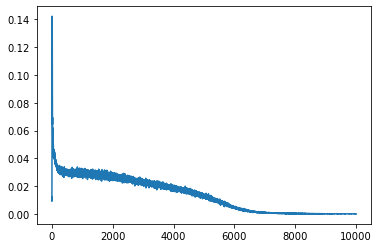

In [15]:
print(loss_history_w1['LD_losses'][0:20])
print()
print(loss_history_w1['LD_losses'][-20:])
# loss_history_w1['LD_losses']

plt.plot(range(10000), loss_history_w1['LD_losses'])

In [19]:
loss_history_w1['LD_losses'][9000:10000]

[0.00025524396914988756,
 0.00025562848895788193,
 0.000203834380954504,
 0.0002470490871928632,
 0.0002495077787898481,
 0.00030534720281139016,
 0.00023824002710171044,
 0.00022413843544200063,
 0.00024399961694143713,
 0.00025616626953706145,
 0.0002597645507194102,
 0.00019835201965179294,
 0.0002875507343560457,
 0.00027226231759414077,
 0.00023309534299187362,
 0.00025420894962735474,
 0.00026884261751547456,
 0.00021699289209209383,
 0.00021639865008182824,
 0.00030837085796520114,
 0.00021423441648948938,
 0.00025062073837034404,
 0.0002683298080228269,
 0.00020335084991529584,
 0.00021378439851105213,
 0.0003146821982227266,
 0.0002367714187130332,
 0.00023532428895123303,
 0.00023997665266506374,
 0.0002504005969967693,
 0.0002946972963400185,
 0.0002533013466745615,
 0.00021257679327391088,
 0.0002597780548967421,
 0.00018697755876928568,
 0.0002884749846998602,
 0.0002808287099469453,
 0.00020586013852152973,
 0.00023243477335199714,
 0.00027748820139095187,
 0.000272319302

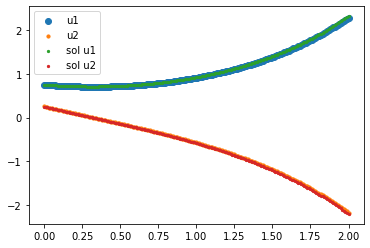

In [16]:
A = [0.75, 0.25]
xx = torch.Tensor(np.linspace(0, 2, 200)[:, None])
u_1 = trained_model_w1(xx)[0][:, 0].detach().numpy()
u_2 = trained_model_w1(xx)[0][:, 1].detach().numpy()

e_term1, e_term2 = np.exp(-1.1 * xx), np.exp(2.2 * xx)

yt1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (0.5 * A[1] * e_term1 * (e_term2 - 1))).numpy()
yt2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - (0.5 * A[0] * e_term1 * (e_term2 - 1))).numpy()

# yt1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (A[1] * e_term1 * (e_term2 - 1)) / np.sqrt(6)).numpy()
# yt2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - 0.5 * np.sqrt(1.5) * A[0] * e_term1 * (e_term2 - 1)).numpy()

# sol1 = A[0] * np.exp(-1 * x)
# sol2 = A[1] * np.exp(-2 * x)

plt.scatter(xx, u_1, label='u1')
plt.scatter(xx, u_2, label='u2', s=10)
plt.scatter(xx, yt1, label='sol u1', s=5)
plt.scatter(xx, yt2, label='sol u2', s=5)
plt.legend()

In [ ]:
# COUPLED VERSION
# A = [0.75, 0.25]
# xx = torch.Tensor(np.linspace(0, 2, 200)[:, None])
# e_term1, e_term2 = np.exp(-np.sqrt(6) * xx), np.exp(2 * np.sqrt(6) * xx)
# yt1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (A[1] * e_term1 * (e_term2 - 1)) / np.sqrt(6)).numpy()
# yt2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - 0.5 * np.sqrt(1.5) * A[0] * e_term1 * (e_term2 - 1)).numpy()

# plt.scatter(xx, yt1)
# plt.scatter(xx, yt2)


A = [0.75, 0.75]
xx = torch.Tensor(np.linspace(0, 2, 200)[:, None])
e_term1, e_term2 = np.exp(-np.sqrt(6) * xx), np.exp(2 * np.sqrt(6) * xx)
yt1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (A[1] * e_term1 * (e_term2 - 1)) / np.sqrt(6)).numpy()
yt2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - 0.5 * np.sqrt(1.5) * A[0] * e_term1 * (e_term2 - 1)).numpy()

plt.scatter(xx, yt1)
plt.scatter(xx, yt2)

In [ ]:
# plot overall loss and network solution for model which has a loss of the MSE (i.e. no higher order terms)
print("\n Model 1: Loss = L_D")
plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                       iterations=iterations, trained_model=trained_model_w1, 
                       train_losses=loss_history_w1['Ltotal_losses'], 
                       loss_label='Total Loss ($L_D$)', mses=MSE_w1)

# plot overall loss and network solution for model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
print("\n Model 2: Loss = L_D + L_DD")
plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                       iterations=iterations, trained_model=trained_model_w2, 
                       train_losses=loss_history_w2['Ltotal_losses'], 
                       loss_label='Total Loss ($L_D + L_{DD}$)', mses=MSE_w2)

if False:
    
    # plot overall loss and network solution for model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    print("\n Model 3: Loss = L_D + L_DD + L_DDD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w3, 
                           train_losses=loss_history_w3['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD} + L_{DDD}$)', mses=MSE_w3)

    # plot overall loss and network solution for model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    print("\n Model 4: Loss = L_D + L_DD + L_DDD + L_DDDD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w4, 
                           train_losses=loss_history_w4['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD} + L_{DDD} + L_{DDDD}$)', mses=MSE_w4)

In [ ]:
if False:
    
    # plot of differential equation residual (L_D) for each updated model
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D$)' : loss_history_w1['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses']})

    # plot of L_D and L_DD when using a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LDD_losses']})

    # plot of L_D, L_DD, and L_DDD when using a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDD_losses'],
                                            '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDDD_losses']})

    # plot of L_D, L_DD, L_DDD, and L_DDDD when using a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDD_losses'],
                                            '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDD_losses'],
                                            '$L_{DDDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDDD_losses']})


In [ ]:
# create a t to take derivative with respect to 
rng = np.random.default_rng()
t_eval = torch.arange(0, 2, 0.001, requires_grad=True)
t_eval = t_eval[rng.integers(low=0, high=2000, size=500)]
t_eval = t_eval.reshape(-1, 1)
# t_eval = torch.tensor([[0.3], [0.1], [0.5]], dtype=torch.float32, requires_grad=True) 

# forward pass to extract H 
output, H = trained_model_w1(t_eval) 

print("H shape before column of 1s: ", H.shape)
H = torch.cat((torch.ones(len(t_eval), 1), H), 1)
print("H shape after column of 1s: ", H.shape)

# compute derivative w/r/t H and multiply it by its transpose
dH_dt = torch.autograd.functional.jacobian(trained_model_w1 ,t_eval, create_graph=True)[1].sum(axis=2)

print("dh_dt before adjusting: ", dH_dt.shape)
dH_dt = torch.cat((torch.zeros(len(t_eval), 1, 1), dH_dt), 1)
print("dh_dt after adjusting: ", dH_dt.shape)

In [ ]:
# Formula error:
# print(dH_dt[499] * new_H[499].T)
# print(new_H[499] * dH_dt[499].T)
# print(new_H[499].T * dH_dt[499])


In [ ]:
# compute dH_dt times dH_dt transpose 
dH_dt_times_dH_dt_T = torch.matmul(dH_dt, dH_dt.mT)
print("dH_dt * dH_dt_T: ", dH_dt_times_dH_dt_T.shape)

# compute dH_dt times H transpose 
new_H = torch.unsqueeze(H, dim=-1)
dH_dt_times_H_T = torch.matmul(dH_dt, new_H.mT)
print("dH_dt * H_T: ", dH_dt_times_H_T.shape)

# compute H times dH_dt transpose
H_times_dH_dt_T = torch.matmul(new_H, dH_dt.mT)

# compute H times H transpose
H_times_H_T = torch.matmul(new_H, new_H.mT)
print("H * H_T: ", H_times_H_T.shape)

# compute the sum of matrices across time
# w_sum_term = dH_dt_times_dH_dt_T + 2 * lambda_val * dH_dt_times_H_T + lambda_val ** 2 * H_times_H_T
w_sum_term = dH_dt_times_dH_dt_T + lambda_val * dH_dt_times_H_T + lambda_val * H_times_dH_dt_T + lambda_val ** 2 * H_times_H_T 

print("W_sum shape before summing across time: ", w_sum_term.shape)
w_sum_term = w_sum_term.sum(axis=0)
w_sum_term = w_sum_term / len(t_eval)
print("W_sum shape after summing across time: ", w_sum_term.shape)

# compute H_0 and multiply it by its transpose 
output_0, H_0 = trained_model_w1(torch.tensor([[0.]], dtype=torch.float32, requires_grad=True))
print("H_0 shape before appending 1: ", H_0.shape)
H_0 = torch.cat((torch.ones(1, 1), H_0), 1)
print("H_0 shape after appending 1: ", H_0.shape)

H_0_T_times_H_0 = torch.matmul(H_0.T, H_0)
print("H_0_T * H_0 shape: ", H_0_T_times_H_0.shape)

In [ ]:
# build the M matrix and find its inverse 
M = w_sum_term + H_0_T_times_H_0
M_inverse = torch.linalg.pinv(M)

# compute W_out
w_out = torch.matmul(M_inverse, H_0.T) * 0.75

In [ ]:
tranfer_learned = [torch.matmul(w_out.T, new_H[i]).item() for i in range(500)]
times = list(t_eval.detach().numpy().squeeze())

true = [0.75 * np.exp(-lambda_val * time) for time in times]
plt.scatter(times, tranfer_learned, label = 'Transfer Learning')
plt.scatter(times, true, label='Analytical', s=10)
plt.xlabel("t")
plt.ylabel('y')
plt.title("Transfer Learning vs Analytical Solution")
plt.legend();

In [ ]:
start_one_shot_time = time.time()
rng = np.random.default_rng(12345)
for i in range(10000):
    random_u_0 = rng.random()
    w_out = torch.matmul(M_inverse, H_0.T) * random_u_0
    
end_one_shot_time = time.time() 
total_one_shot = end_one_shot_time - start_one_shot_time
print(f"Total Time to evaluate w_out for 10000 different initial conditions: {total_one_shot: .2f} seconds")

In [ ]:
# TODO:

# 1. make code work with 2 linear ODEs

# 2. make the code generalize to a system of n ODEs

# 3. compute the individual terms needed in the w_out calculation for a system

# 4. see how formula works and what can be changed while still doing it in "one shot"

# 5. Are the higher order terms, L_D and L_DD, etc.. still relevant?

# 6. see which parts of the formula are dependent on time and ask Pavlos how that works
    # (changing W_o means that only u_o will change eventually?)

# 7. try using a different diff. equation

# 9. make loss function proper


In [ ]:
residuals = (torch.matmul(w_out.T, dH_dt[:]) + lambda_val * torch.matmul(w_out.T, new_H[:])) ** 2
residuals = residuals.reshape(500, 1).detach().numpy()

print(f"Mean of residuals: {residuals.mean()}")
initial_cond_residuals = (torch.matmul(w_out.T, H_0.T) - 0.75) ** 2
print(f"Initial Condition Residual: {initial_cond_residuals.item()}")

plt.plot(residuals);
plt.xlabel("t")
plt.ylabel("Residual")
plt.title("Plot of Residuals");

In [ ]:
print(f"Difference Between Analytical and Tranfer Learned for t ={times[0]: .3f}: {(0.75 * np.exp(-lambda_val * times[0]) - torch.matmul(w_out.T, H[0])).item(): .5f}")
print(f"Difference Between Analytical and Tranfer Learned for t ={times[100]: .3f}: {(0.75 * np.exp(-lambda_val * times[100]) - torch.matmul(w_out.T, H[100])).item(): .5f}")
print(f"Difference Between Analytical and Tranfer Learned for t ={times[200]: .3f}: {(0.75 * np.exp(-lambda_val * times[200]) - torch.matmul(w_out.T, H[200])).item(): .5f}")

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# H_test = H.detach()
# gm_H = torch.matmul(H_test.T, H_test)
# pca = PCA(n_components=5)
# pca.fit(gm_H)
# print(pca.explained_variance_ratio_)

# Appendix

### Notes:

- $u_t = lambda$ $t: A + t * model(t)$ is outdated, so we use $ u_t = lambda$ $t: A + (1 - exp(-t)) * model(t)$

- We are solving $\frac{du}{dt} + \lambda * u = 0$ where $f = -\lambda * u$

- Old Model Code: model = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64,1))

- Old solution parametrization: u_t = lambda t: A + (1 - torch.exp(-t)) * model(t)

- Original normalization term: norm_term = 1 / u_t(torch.tensor([[0]], dtype=torch.float32)) ** 2